### IMPORTING LIBRARIES

In [267]:
import sys
print(sys.version)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


In [185]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
sns.color_palette("husl")
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_blobs
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
import jax.numpy as jnp
import numpyro
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from lightweight_mmm import plot
import pandas as pd
import numpy as np
from lightweight_mmm import preprocessing, lightweight_mmm, plot, optimize_media
import jax.numpy as jnp
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import display

### CONNECTING TO BIG QUERY

In [186]:
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
'hg-analytics-316512-709a9ea9b180.json')
project_id = 'hg-analytics-316512'
client = bigquery.Client(credentials= credentials,project=project_id)

### IMPORTING DATA USING SQL QUERY

In [257]:
query_job = client.query("""
WITH campaign_stats AS (
    SELECT 
        coalesce(key_market, campaignstats.market) AS market,brand,
        key_channel,key_date,
        SUM(impressions) AS total_impressions,
        SUM(clicks) AS total_clicks,
        SUM(video_views) AS total_video_views,
        SUM(cost_eur) AS total_spend,
        case when lower(key_campaign) like '%performance%' then 'New'
when lower(key_campaign) like '%video%' then 'New'
when lower(key_campaign)  like '%awareness%' then 'New'
when lower(key_campaign)  like '%tactical%' then 'Convert'
when lower(key_campaign) like '%discovery%' then 'New'
when lower(key_campaign) like '%lead%' then 'New' ELSE 'Not_Mapped' END AS Tactic
    FROM `datawarehouse_prod.fact_campaign_stats` campaignstats inner join `datawarehouse_prod.dim_campaign` campaign on campaignstats.key_campaign=campaign.master_campaign_id 
   
        
     where key_campaign IS NOT NULL
    
    GROUP BY market, key_channel,key_date,Tactic,brand
),


fact_conversion AS (
    SELECT 
        key_market,
        key_channel,key_date,brand,
         SUM(revenue_eur) as revenue,
        SUM(total_conversions) AS conversions,
        case when lower(key_campaign) like '%performance%' then 'New'
when lower(key_campaign) like '%video%' then 'New'
when lower(key_campaign)  like '%awareness%' then 'New'
when lower(key_campaign)  like '%tactical%' then 'Convert'
when lower(key_campaign) like '%discovery%' then 'New'
when lower(key_campaign) like '%lead%' then 'New' ELSE 'Not_Mapped' END AS Tactic,
    FROM `datawarehouse_dev.fact_conversion` conversion inner join `datawarehouse_prod.dim_campaign` campaign on conversion.key_campaign=campaign.master_campaign_id 
   
        
     where key_campaign IS NOT NULL 
     
    and key_campaign is not null and activity<>'Hurtigruten Global Page' 
    GROUP BY key_market, key_channel,key_date,Tactic,brand 
)

SELECT 
date.full_date,c.brand,
    c.market,
    c.key_channel,
    c.total_impressions,
    c.total_clicks,
    c.total_video_views,
    c.total_spend,
    fc.conversions,revenue,c.tactic
FROM campaign_stats c 
INNER JOIN fact_conversion fc ON c.market = fc.key_market and c.brand = fc.brand AND c.key_channel = fc.key_channel and fc.key_date=c.key_date and c.tactic=fc.tactic
INNER JOIN `datawarehouse_prod.dim_date` date on date.key_date=c.key_date where c.tactic<>'Not_Mapped'
;
       
 """) 
data = query_job.to_dataframe()

In [188]:
data.isna().sum()

full_date                0
brand                    0
market                   0
key_channel              0
total_impressions       45
total_clicks            47
total_video_views      165
total_spend           6315
conversions              0
revenue              38380
tactic                   0
dtype: int64

### EXPLORATORY DATA ANALYSIS AND DATA CLEANING

In [261]:
# Identify columns with missing values
columns_with_na = data.columns[data.isna().any()]
# Fill NA values in columns with missing values
data[columns_with_na] = data[columns_with_na].fillna(0)
data['revenue']=data['revenue'].astype(int)

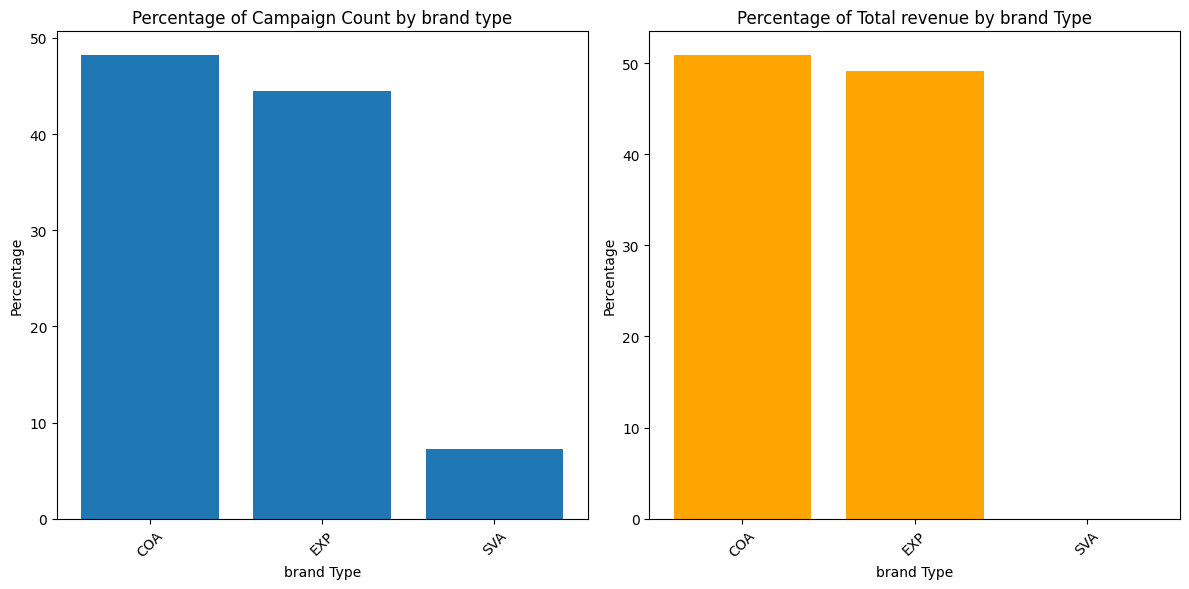

In [12]:
# Group by brand and calculate count and sum
grouped_data = data.groupby('brand').agg({'brand': 'count', 'revenue': 'sum'})

# Rename columns for clarity
grouped_data.columns = ['brand Type Count', 'Total revenue']

# Calculate percentages
grouped_data['Count Percentage'] = grouped_data['brand Type Count'] / grouped_data['brand Type Count'].sum() * 100
grouped_data['revenue Percentage'] = grouped_data['Total revenue'] / grouped_data['Total revenue'].sum() * 100

# Reset index for plotting
grouped_data = grouped_data.reset_index()

# Create two separate bar charts
plt.figure(figsize=(12, 6))

# Bar chart for Count Percentage
plt.subplot(1, 2, 1)
plt.bar(grouped_data['brand'], grouped_data['Count Percentage'])
plt.xlabel('brand Type')
plt.ylabel('Percentage')
plt.title('Percentage of Campaign Count by brand type')
plt.xticks(rotation=45)
plt.tight_layout()

# Bar chart for revenue Percentage
plt.subplot(1, 2, 2)
plt.bar(grouped_data['brand'], grouped_data['revenue Percentage'], color='orange')
plt.xlabel('brand Type')
plt.ylabel('Percentage')
plt.title('Percentage of Total revenue by brand Type')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


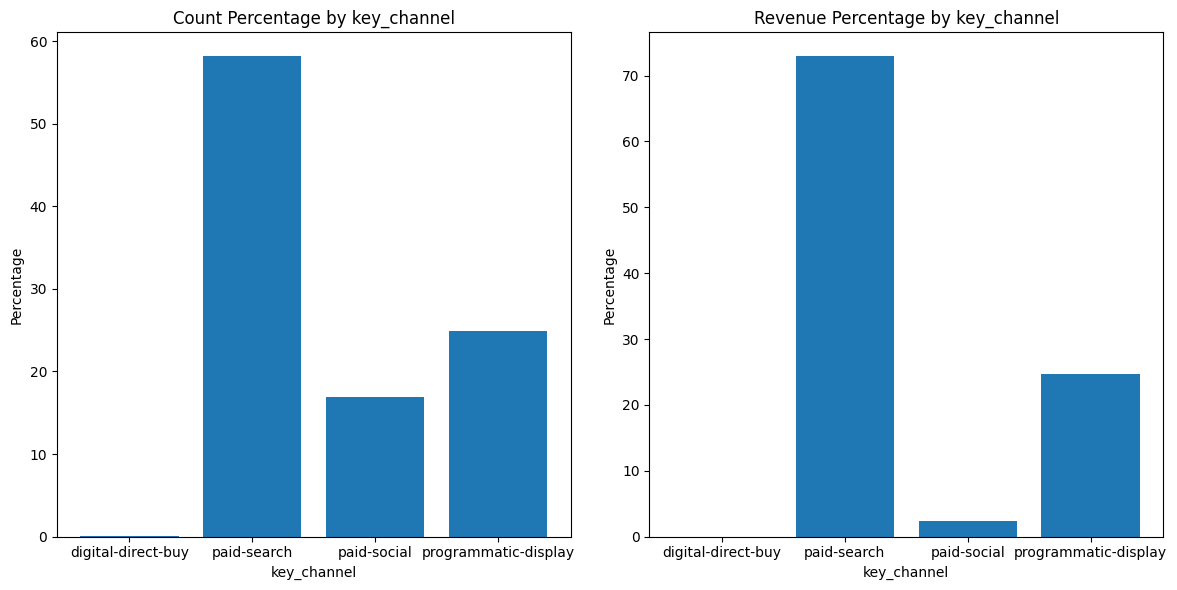

In [15]:

# Group data by key_channel and calculate count and revenue sum
key_channel_grouped = data.groupby('key_channel').agg({'brand': 'count', 'revenue': 'sum'}).reset_index()

# Calculate percentage columns
total_count = key_channel_grouped['brand'].sum()
total_revenue = key_channel_grouped['revenue'].sum()
key_channel_grouped['Count_Percentage'] = (key_channel_grouped['brand'] / total_count) * 100
key_channel_grouped['revenue_Percentage'] = (key_channel_grouped['revenue'] / total_revenue) * 100

# Plot the bar charts
plt.figure(figsize=(12, 6))

# Count Percentage Bar Chart
plt.subplot(1, 2, 1)
plt.bar(key_channel_grouped['key_channel'], key_channel_grouped['Count_Percentage'])
plt.title('Count Percentage by key_channel')
plt.xlabel('key_channel')
plt.ylabel('Percentage')

# revenue Percentage Bar Chart
plt.subplot(1, 2, 2)
plt.bar(key_channel_grouped['key_channel'], key_channel_grouped['revenue_Percentage'])
plt.title('Revenue Percentage by key_channel')
plt.xlabel('key_channel')
plt.ylabel('Percentage')

plt.tight_layout()
plt.show()


In [17]:
# Group data by key_channel and Market, calculate revenue sum
grouped = data.groupby(['key_channel', 'market']).agg({'revenue': 'sum'}).reset_index()

# Calculate total revenues for normalization
total_revenues = grouped.groupby('key_channel')['revenue'].transform('sum')

# Replace zero revenues with a small value to avoid division by zero
total_revenues = total_revenues.replace(0, 0.001)

# Calculate revenue percentage columns
grouped['revenue_Percentage'] = (grouped['revenue'] / total_revenues) * 100

# Pivot the data to create a table
pivot_table = grouped.pivot(index='market', columns='key_channel', values='revenue_Percentage')

# Convert NaN values to zero
pivot_table = pivot_table.fillna(0)
# Format percentages to one decimal place
pivot_table = pivot_table.applymap(lambda x: f'{x:.1f}%')
# Display the pivot table
pivot_table

key_channel,digital-direct-buy,paid-search,paid-social,programmatic-display
market,,,,
Australia,0.0%,0.5%,0.0%,0.0%
Belgium,0.0%,0.5%,0.0%,0.0%
Denmark,0.0%,0.2%,4.0%,2.9%
France,0.0%,5.4%,1.0%,5.5%
Germany,0.0%,23.9%,8.8%,14.5%
Global,0.0%,0.0%,0.0%,0.0%
Italy,0.0%,1.5%,0.0%,0.0%
Netherlands,0.0%,1.1%,0.0%,0.0%
Norway,0.0%,20.3%,24.5%,17.0%


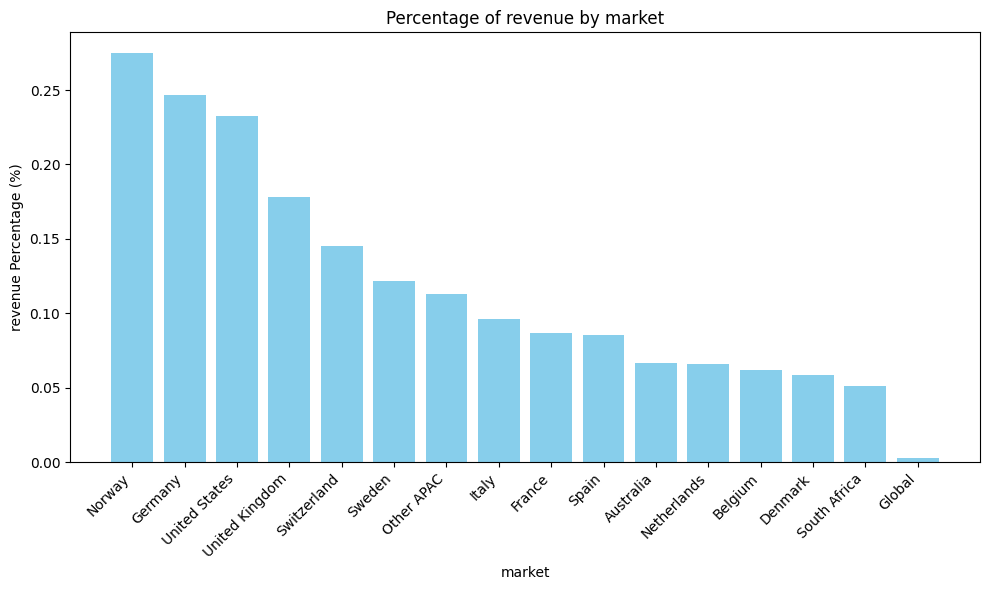

In [19]:

# Calculate total revenue
total_revenue = data['revenue'].sum()

# Calculate percentage of revenue
data['revenue_Percentage'] = (data['revenue'] / total_revenue) * 100

# Sort the DataFrame by revenue_Percentage in descending order
df = data.sort_values(by='revenue_Percentage', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df['market'], df['revenue_Percentage'], color='skyblue')
plt.xlabel('market')
plt.ylabel('revenue Percentage (%)')
plt.title('Percentage of revenue by market')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


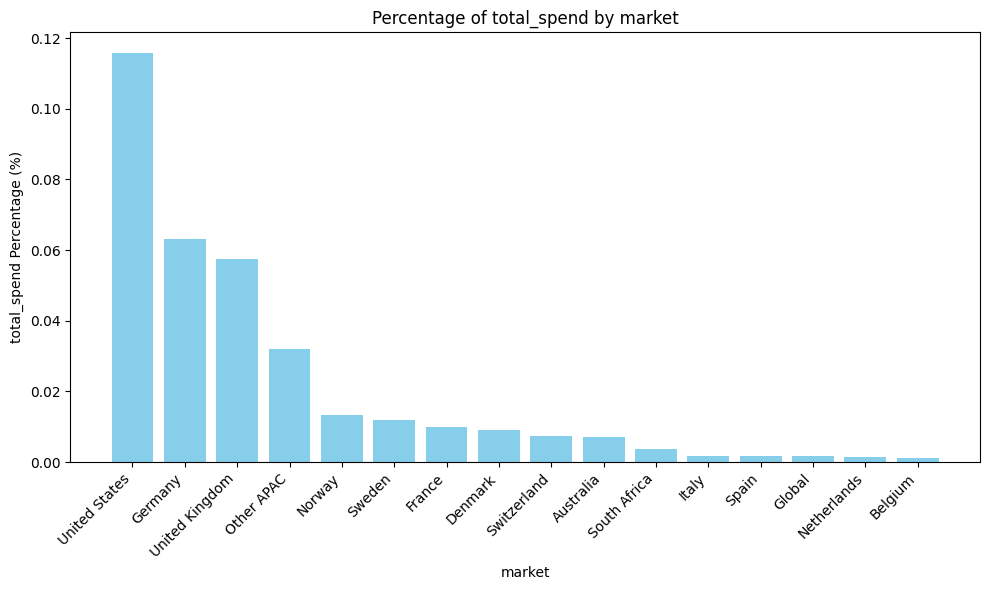

In [27]:
total_revenue = float(total_revenue)

# Calculate total revenue
total_total_spend = data['total_spend'].sum()

# Calculate percentage of revenue
data['total_spend_Percentage'] = (data['total_spend'] / total_revenue) * 100

# Sort the DataFrame by Revenue_Percentage in descending order
df = data.sort_values(by='total_spend_Percentage', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df['market'], df['total_spend_Percentage'], color='skyblue')
plt.xlabel('market')
plt.ylabel('total_spend Percentage (%)')
plt.title('Percentage of total_spend by market')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [189]:
##Taking Top 5 markets for analysis and excluding digital-direct channel as it is less than 1% budget and revenue
topfivemarkets = ['United Kingdom', 'United States', 'Norway', 'Germany', 'Other APAC']
data = data[data['market'].isin(topfivemarkets)]
data=data[data['key_channel']!='digital-direct-buy']

### LIGHT WEIGHT MEDIA MIX MODELLING-GEO LEVEL ANALYSIS

In [251]:
### FUNCTIONS FOR MODEL

## function to get filtered data for Coast/Expedition for New/Convert campaigns
def filtered_dataframe(brand,tactic):
    filtered_data = data[(data['tactic'] == tactic) & (data['brand'] == brand)]
    return filtered_data


## function to group dataframes in required format
def grouped_dataframe(dataframe):
    df = dataframe.groupby(["full_date", "key_channel","market"])[["total_impressions","total_clicks","total_video_views","conversions","total_spend","revenue"]].sum()
    return df


## fucntion to create media,sale,cost and extra features data
def create_model_data(dataframe):
    
    media_data_raw_ = dataframe['total_spend'].unstack(level=1).fillna(0) 
    #conversion is taken as the kpi for new campaigns
    sales_raw_ = dataframe['revenue'].reset_index().groupby(["full_date", "market"]).sum()
    costs_raw = dataframe.groupby(["full_date", "key_channel"])[["total_spend"]].sum().unstack()
    extra_raw_=dataframe[["total_impressions","total_clicks","total_video_views","conversions"]].groupby(["full_date", "market"]).sum()
    return media_data_raw_,sales_raw_,costs_raw,extra_raw_



##function to get max market size
def get_max_market_size(dataframe,media_data_raw_,sales_raw_,extra_raw_):
    max_size = 0
    for market in list(dataframe['market'].unique()):
        df_ = media_data_raw_.loc[(media_data_raw_.index.get_level_values(0), market), :].values
        sdf_ = sales_raw_.loc[(sales_raw_.index.get_level_values(0), market), :].values
        edf_=extra_raw_.loc[(extra_raw_.index.get_level_values(0), market), :].values
    
        max_size = max(max_size, df_.shape[0], sdf_.shape[0],edf_.shape[0])
    return max_size
    
    
##function to pre-process data for modelling
def preprocess_data(dataframe, media_data_raw_, sales_raw_,costs_raw,extra_raw_,split_point,max_size):
    media_concat = list()
    sales_concat = list()
    extra_concat=list()

    # Find the maximum size along the 0th dimension
    for market in list(dataframe['market'].unique()):
    #list(dataframe['market'].unique()):
        df_ = media_data_raw_.loc[(media_data_raw_.index.get_level_values(0), market), :].values
        sdf_ = sales_raw_.loc[(sales_raw_.index.get_level_values(0), market), :].values
        edf_=extra_raw_.loc[(extra_raw_.index.get_level_values(0), market), :].values

        # Calculate the necessary padding as positive difference
        pad_size = max_size - df_.shape[0]
        if pad_size > 0:
            df_padded = np.pad(df_, ((0, pad_size), (0, 0)), mode='constant')
            sdf_padded = np.pad(sdf_, ((0, pad_size), (0, 0)), mode='constant')
            edf_padded=np.pad(edf_, ((0, pad_size), (0, 0)), mode='constant')
        else:
            df_padded = df_
            sdf_padded = sdf_
            edf_padded=edf_

        # Expand dimensions for the third axis
        df_padded = np.expand_dims(df_padded, axis=2)
        edf_padded=np.expand_dims(edf_padded, axis=2)

        # Append the padded arrays to media_concat and sales_concat
        media_concat.append(df_padded)
        sales_concat.append(sdf_padded)
        extra_concat.append(edf_padded)

    # Concatenate the padded arrays
    media_data_raw = np.concatenate(media_concat, axis=2)
    sales_raw = np.concatenate(sales_concat, axis=1)
    extra_raw=np.concatenate(extra_concat, axis=2)

    # Splitting the data into train and test and scaling it
    split_point = split_point
    media_data_test = media_data_raw[:split_point, :, :]
    media_data_train = media_data_raw[split_point:, :, :]
    target_test = sales_raw[:split_point, :]
    target_train = sales_raw[split_point:, :]
    extra_test = extra_raw[:split_point, :, :]
    extra_train = extra_raw[split_point:, :, :]
    media_names = media_data_raw_.columns
    costs_train = costs_raw.iloc[split_point:].sum(axis=0)
    media_scaler = preprocessing.CustomScaler()
    target_scaler = preprocessing.CustomScaler()
    cost_scaler = preprocessing.CustomScaler()
    extra_scaler = preprocessing.CustomScaler()
    

    media_data_train = media_data_train.astype(np.float32)
    extra_train = extra_train.astype(np.float32)
    extra_train_scaled = extra_scaler.fit_transform(extra_train)
    extra_test=extra_test.astype(np.float32)
    extra_test_scaled=extra_scaler.fit_transform(extra_test)
    media_data_train_scaled = media_scaler.fit_transform(media_data_train)
    target_train = target_train.astype(np.float32)
    target_train_scaled = target_scaler.fit_transform(target_train.squeeze())
    costs_train = costs_train.values.astype(np.float32)  # Convert to NumPy array
    costs_scaled = cost_scaler.fit_transform(costs_train)
    media_data_test_scaled = media_scaler.transform(media_data_test)
    
    return (media_data_train_scaled, media_data_test_scaled, target_train_scaled, target_test,
            media_names, costs_scaled,extra_train_scaled,media_data_raw,sales_raw,extra_raw,extra_test_scaled,extra_test)

##function to check quality of data:
def data_quality_check(media_data_train_scaled,target_train_scaled,costs_scaled,extra_train_scaled):
    correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_data_train_scaled,
    target_data=target_train_scaled,
    cost_data=costs_scaled,
    extra_features_data=extra_train_scaled
    )
    return correlations, variances, spend_fractions, variance_inflation_factors

    
    
##variance of feature over time
def highlight_variances(x: float, 
                        low_variance_threshold: float=1.0e-3, 
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style




##funtion to check fraction of spend
def highlight_low_spend_fractions(x: float,
                                  low_spend_threshold: float=0.01) -> str:
    if x < low_spend_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style



##function to check variance inflation factors
def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style


## function to train the model

def model_train(model_name):
    mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
    return mmm

##function to optimise budget

def optimal_budget(media_data_raw_,media_data_raw,extra_test,mmm):
    media_scaler = preprocessing.CustomScaler()
    target_scaler = preprocessing.CustomScaler()
    cost_scaler = preprocessing.CustomScaler()
    extra_scaler = preprocessing.CustomScaler()
    n_media_channels=len(media_data_raw_.columns)
    prices = jnp.ones(mmm.n_media_channels)
    n_time_periods=60
    budget = jnp.sum(jnp.dot(prices, media_data_raw.mean(axis=0)))* n_time_periods
    solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_scaler.transform(extra_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

    # Obtain the optimal weekly allocation.
    optimal_buget_allocation = prices * solution.x
    optimal_buget_allocation

    # similar renormalization to get previous budget allocation
    previous_budget_allocation = prices * previous_media_allocation
    previous_budget_allocation

    # Both these values should be very close in order to compare KPI
    budget, optimal_buget_allocation.sum()
    # Both numbers should be almost equal
    budget, jnp.sum(solution.x * prices)
    return previous_budget_allocation,optimal_buget_allocation,solution,kpi_without_optim

media_scaler = preprocessing.CustomScaler()
target_scaler = preprocessing.CustomScaler()
cost_scaler = preprocessing.CustomScaler()

### BRAND=COAST, TACTIC=NEW

In [195]:
#creating filtered df
coast_new=filtered_dataframe('COA','New')

In [198]:
##less than 5% of the budget is allocated to these channels
channels_to_exclude = ['digital-direct-buy']
coast_new = coast_new[~coast_new['key_channel'].isin(channels_to_exclude)]

#grouping as per requirement
coast_new_grouped_dataframe=grouped_dataframe(coast_new)

#creating data required for model
media_data_raw_coast_new,sales_raw_coast_new,costs_raw_coast_new,extra_raw_coast_new=create_model_data(coast_new_grouped_dataframe)

#max market size
max_size_coast_new=get_max_market_size(coast_new,media_data_raw_coast_new,sales_raw_coast_new,extra_raw_coast_new)

#preprocessing data
split_point=60
media_data_train_scaled_coast_new, media_data_test_scaled_coast_new, target_train_scaled_coast_new, target_test_coast_new,media_names_coast_new, costs_scaled_coast_new, extra_train_scaled_coast_new,media_data_rawcoast_new,sales_rawcoast_new,extra_rawcoast_new,extra_test_scaled_coast_new,extra_test_coast_new=preprocess_data(coast_new,media_data_raw_coast_new,sales_raw_coast_new,costs_raw_coast_new,extra_raw_coast_new,split_point,max_size_coast_new)

#data 
correlations_coast_new, variances_coast_new, spend_fractions_coast_new, variance_inflation_factors_coast_new=data_quality_check(media_data_train_scaled_coast_new,target_train_scaled_coast_new,costs_scaled_coast_new,extra_train_scaled_coast_new)

In [199]:
from IPython.display import display

for i, corr_matrix in enumerate(correlations_coast_new):
 display(f"geo {i}")
 display(corr_matrix.style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_precision(3))
 display("--------------------------------------------------------------------")

'geo 0'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,-0.224,0.174,0.828,-0.205,0.395,0.075
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,-0.224,nan,1.000,0.644,0.034,0.984,0.152,-0.007
extra_feature_0,0.174,nan,0.644,1.000,0.484,0.626,0.183,-0.003
extra_feature_1,0.828,nan,0.034,0.484,1.000,0.041,0.468,0.071
extra_feature_2,-0.205,nan,0.984,0.626,0.041,1.000,0.151,-0.006
extra_feature_3,0.395,nan,0.152,0.183,0.468,0.151,1.000,0.226
target,0.075,nan,-0.007,-0.003,0.071,-0.006,0.226,1.000


'--------------------------------------------------------------------'

'geo 1'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,nan,0.017,0.587,-0.053,0.158,-0.011
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,nan,nan,nan,nan,nan,nan,nan,nan
extra_feature_0,0.017,nan,nan,1.000,0.352,0.965,-0.029,-0.011
extra_feature_1,0.587,nan,nan,0.352,1.000,0.213,0.135,0.001
extra_feature_2,-0.053,nan,nan,0.965,0.213,1.000,-0.039,-0.009
extra_feature_3,0.158,nan,nan,-0.029,0.135,-0.039,1.000,0.103
target,-0.011,nan,nan,-0.011,0.001,-0.009,0.103,1.000


'--------------------------------------------------------------------'

'geo 2'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,nan,0.568,0.819,nan,0.532,0.068
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,nan,nan,nan,nan,nan,nan,nan,nan
extra_feature_0,0.568,nan,nan,1.000,0.815,nan,0.109,0.065
extra_feature_1,0.819,nan,nan,0.815,1.000,nan,0.398,0.058
extra_feature_2,nan,nan,nan,nan,nan,nan,nan,nan
extra_feature_3,0.532,nan,nan,0.109,0.398,nan,1.000,0.101
target,0.068,nan,nan,0.065,0.058,nan,0.101,1.000


'--------------------------------------------------------------------'

'geo 3'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,nan,0.488,0.444,nan,0.240,0.037
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,nan,nan,nan,nan,nan,nan,nan,nan
extra_feature_0,0.488,nan,nan,1.000,0.808,nan,-0.004,-0.014
extra_feature_1,0.444,nan,nan,0.808,1.000,nan,0.103,-0.004
extra_feature_2,nan,nan,nan,nan,nan,nan,nan,nan
extra_feature_3,0.240,nan,nan,-0.004,0.103,nan,1.000,0.222
target,0.037,nan,nan,-0.014,-0.004,nan,0.222,1.000


'--------------------------------------------------------------------'

'geo 4'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,nan,0.019,0.674,-0.017,0.548,0.038
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,nan,nan,nan,nan,nan,nan,nan,nan
extra_feature_0,0.019,nan,nan,1.000,0.381,0.768,0.046,0.006
extra_feature_1,0.674,nan,nan,0.381,1.000,0.116,0.586,0.087
extra_feature_2,-0.017,nan,nan,0.768,0.116,1.000,0.007,0.019
extra_feature_3,0.548,nan,nan,0.046,0.586,0.007,1.000,0.214
target,0.038,nan,nan,0.006,0.087,0.019,0.214,1.000


'--------------------------------------------------------------------'

In [200]:
spend_fractions_coast_new.style.set_precision(4).applymap(highlight_low_spend_fractions)

,fraction of spend
feature_0,0.9828
feature_1,0.0083
feature_2,0.0089


In [201]:
variance_inflation_factors_coast_new.style.set_precision(4).applymap(highlight_high_vif_values)

,geo_0,geo_1,geo_2,geo_3,geo_4
feature_0,4.2278,1.6495,3.6949,1.4248,2.2833
feature_1,nan,nan,nan,nan,nan
feature_2,34.6763,nan,nan,nan,nan
extra_feature_0,3.0194,22.2519,3.6842,3.2180,3.8836
extra_feature_1,5.5830,2.3846,7.0466,2.9900,3.4176
extra_feature_2,31.7556,20.1556,nan,nan,2.9301
extra_feature_3,1.4002,1.0333,1.5741,1.1119,1.7119


In [202]:
number_warmup=1000
number_samples=1000
SEED=105    
mmm_coast_new=model_train("adstock")
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm_coast_new.fit(
    media=media_data_train_scaled_coast_new,
    media_prior=costs_scaled_coast_new,
    target=target_train_scaled_coast_new,
    extra_features=extra_train_scaled_coast_new,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED,
weekday_seasonality=True,
seasonality_frequency=365)

sample: 100%|███████████████████████████| 2000/2000 [00:11<00:00, 178.49it/s, 3 steps of size 2.50e-08. acc. prob=0.83]


In [203]:
mmm_coast_new.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
 channel_coef_media[0,0] 965917.62 102023.00 965919.25 863922.25 1067916.25      1.00  26104.85
 channel_coef_media[1,0]   8928.55   2099.12   8928.65   6830.05  11027.25      1.00  52045.12
 channel_coef_media[2,0]   5430.08    296.98   5430.07   5133.16   5726.97      1.00  21534.62
coef_extra_features[0,0]     -0.29      0.14     -0.29     -0.43     -0.15      1.00  99238.69
coef_extra_features[0,1]     -0.10      0.51     -0.10     -0.61      0.41      1.00 309122.62
coef_extra_features[0,2]      0.04      0.24      0.04     -0.20      0.29      1.00 492675.97
coef_extra_features[0,3]     -0.08      0.02     -0.08     -0.10     -0.06      1.00  41221.86
coef_extra_features[0,4]     -0.23      0.03     -0.23     -0.26     -0.20      1.00  44981.06
coef_extra_features[1,0]     -0.19      0.19     -0.19     -0.38     -0.00      1.00 142673.44
coef_extra_features[1,1]      0.11      0.47    

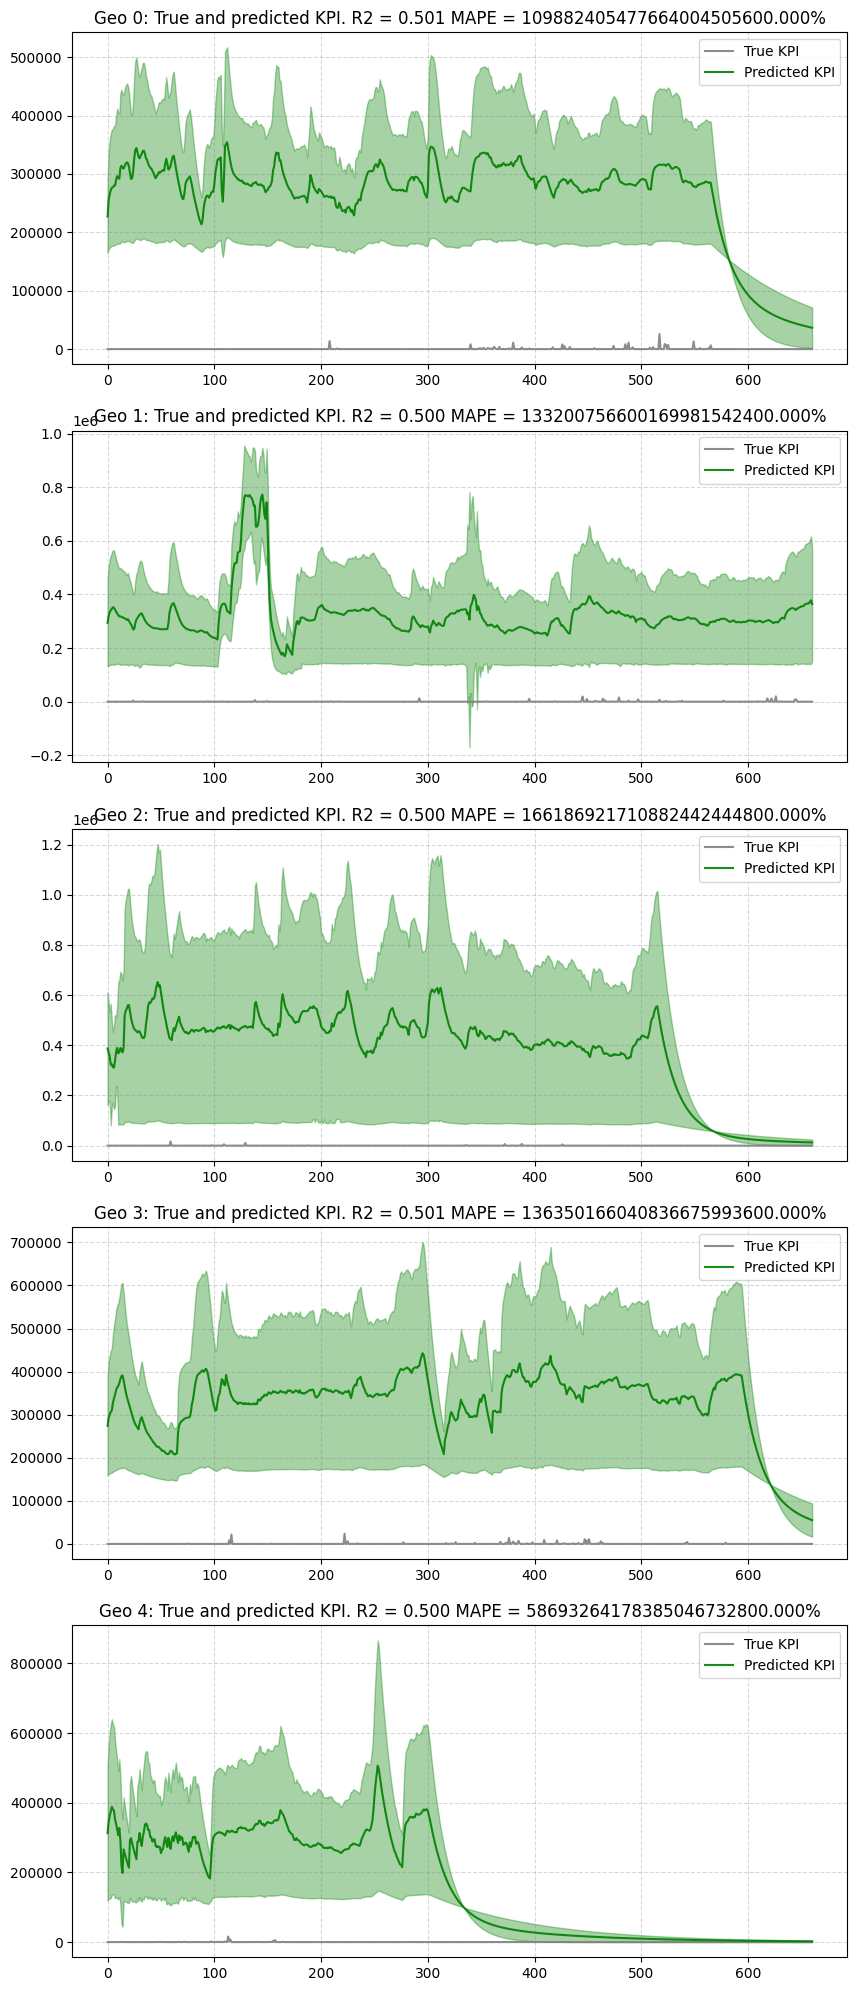

In [81]:
plot.plot_model_fit(mmm_coast_new, target_scaler=target_scaler)

In [84]:
media_contribution_coast_new, roi_hat_coast_new = mmm_coast_new.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

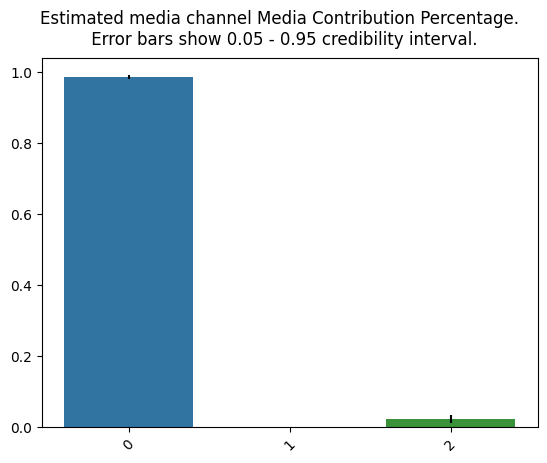

In [85]:
plot.plot_bars_media_metrics(metric=media_contribution_coast_new, metric_name="Media Contribution Percentage")

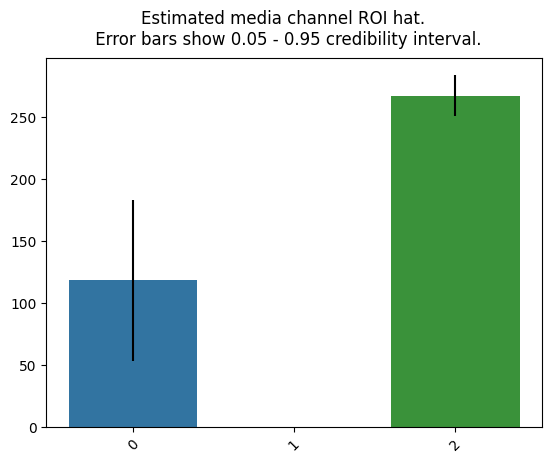

In [86]:
plot.plot_bars_media_metrics(metric=roi_hat_coast_new, metric_name="ROI hat")

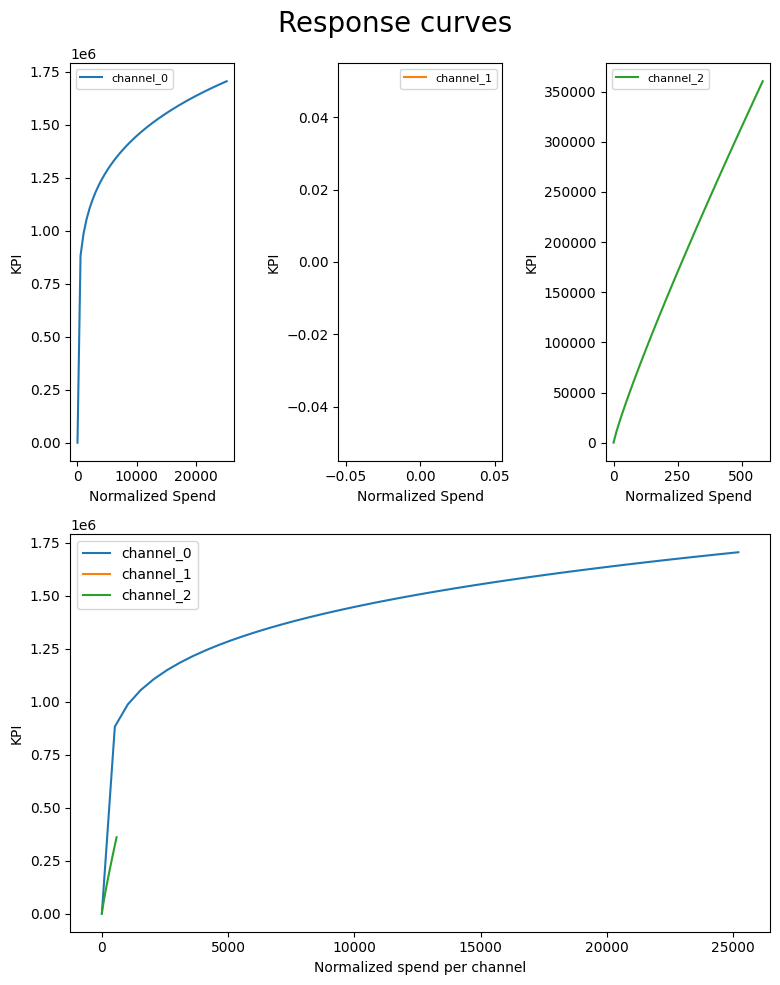

In [88]:
plot.plot_response_curves(
    media_mix_model=mmm_coast_new, target_scaler=target_scaler, seed=SEED)

In [89]:
previous_budget_allocation_coast_new,optimal_buget_allocation_coast_new,solution_coast_new,kpi_without_optim_coast_new=optimal_budget(media_data_raw_coast_new,media_data_rawcoast_new,extra_test_coast_new,mmm_coast_new)

Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


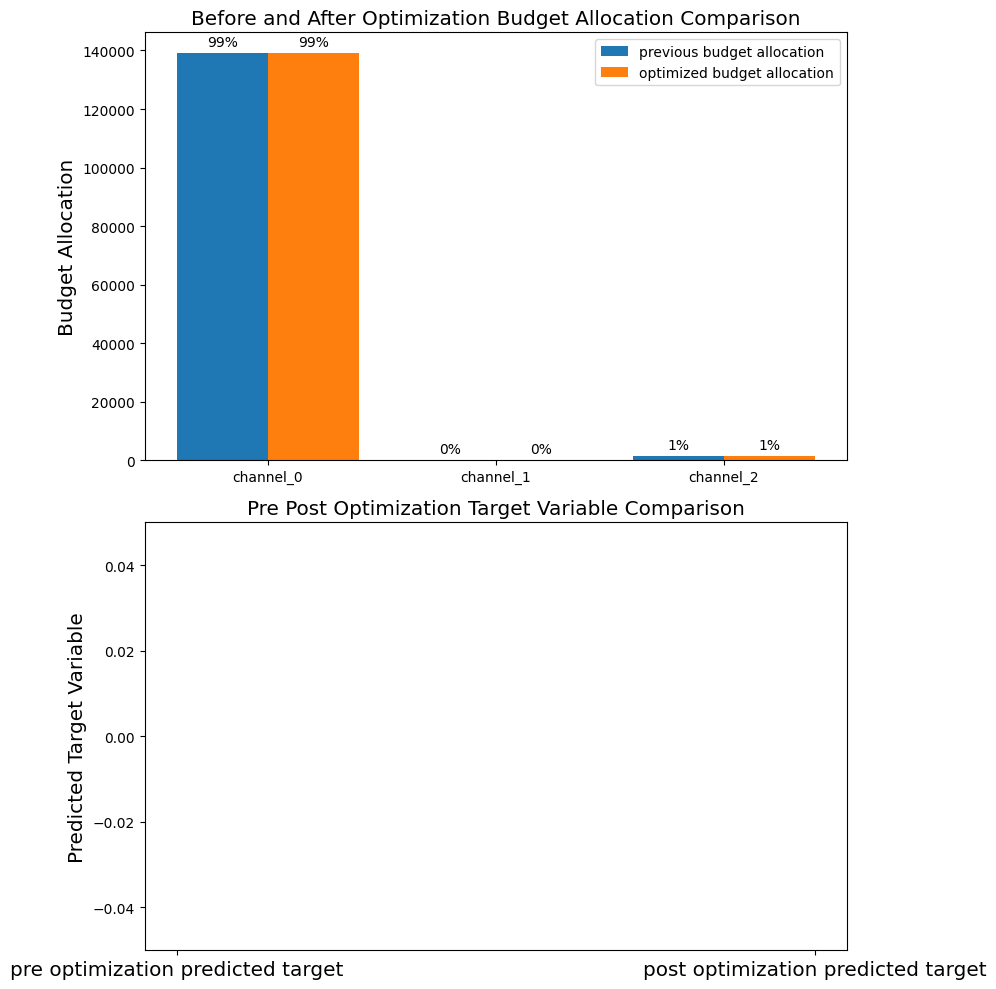

In [90]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm_coast_new, 
                                                kpi_with_optim=solution_coast_new['fun'], 
                                                kpi_without_optim=kpi_without_optim_coast_new,
                                                optimal_buget_allocation=optimal_buget_allocation_coast_new, 
                                                previous_budget_allocation=previous_budget_allocation_coast_new,
                                                figure_size=(10,10))

### COAST CONVERT

In [91]:
#creating filtered df
coast_convert=filtered_dataframe('COA','Convert')

##less than 5% of the budget is allocated to these channels
channels_to_exclude = ['digital-direct-buy']
coast_convert = coast_convert[~coast_convert['key_channel'].isin(channels_to_exclude)]

#grouping as per requirement
coast_convert_grouped_dataframe=grouped_dataframe(coast_convert)

#creating data required for model
media_data_raw_coast_convert,sales_raw_coast_convert,costs_raw_coast_convert,extra_raw_coast_convert=create_model_data(coast_convert_grouped_dataframe)

#max market size
max_size_coast_convert=get_max_market_size(coast_convert,media_data_raw_coast_convert,sales_raw_coast_convert,extra_raw_coast_convert)

#preprocessing data
split_point=60
media_data_train_scaled_coast_convert, media_data_test_scaled_coast_convert, target_train_scaled_coast_convert, target_test_coast_convert,media_names_coast_convert, costs_scaled_coast_convert, extra_train_scaled_coast_convert,media_data_rawcoast_convert,sales_rawcoast_convert,extra_rawcoast_convert,extra_test_scaled_coast_convert,extra_test_coast_convert=preprocess_data(coast_convert,media_data_raw_coast_convert,sales_raw_coast_convert,costs_raw_coast_convert,extra_raw_coast_convert,split_point,max_size_coast_convert)

#data 
correlations_coast_convert, variances_coast_convert, spend_fractions_coast_convert, variance_inflation_factors_coast_convert=data_quality_check(media_data_train_scaled_coast_convert,target_train_scaled_coast_convert,costs_scaled_coast_convert,extra_train_scaled_coast_convert)

In [92]:
from IPython.display import display

for i, corr_matrix in enumerate(correlations_coast_convert):
 display(f"geo {i}")
 display(corr_matrix.style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_precision(3))
 display("--------------------------------------------------------------------")

'geo 0'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,0.325,0.369,0.502,0.425,0.310,0.053
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,0.325,nan,1.000,0.786,0.507,0.314,0.337,0.037
extra_feature_0,0.369,nan,0.786,1.000,0.690,0.567,0.317,0.095
extra_feature_1,0.502,nan,0.507,0.690,1.000,0.302,0.449,0.087
extra_feature_2,0.425,nan,0.314,0.567,0.302,1.000,0.092,0.037
extra_feature_3,0.310,nan,0.337,0.317,0.449,0.092,1.000,0.199
target,0.053,nan,0.037,0.095,0.087,0.037,0.199,1.000


'--------------------------------------------------------------------'

'geo 1'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,0.054,0.532,0.246,0.661,0.247,0.039
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,0.054,nan,1.000,0.588,0.619,0.249,0.203,-0.018
extra_feature_0,0.532,nan,0.588,1.000,0.725,0.771,0.226,-0.026
extra_feature_1,0.246,nan,0.619,0.725,1.000,0.381,0.372,0.001
extra_feature_2,0.661,nan,0.249,0.771,0.381,1.000,0.086,-0.057
extra_feature_3,0.247,nan,0.203,0.226,0.372,0.086,1.000,0.207
target,0.039,nan,-0.018,-0.026,0.001,-0.057,0.207,1.000


'--------------------------------------------------------------------'

'geo 2'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,0.189,0.531,0.591,0.476,0.310,0.175
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,0.189,nan,1.000,0.724,0.624,0.529,0.285,0.087
extra_feature_0,0.531,nan,0.724,1.000,0.721,0.688,0.351,0.178
extra_feature_1,0.591,nan,0.624,0.721,1.000,0.418,0.412,0.155
extra_feature_2,0.476,nan,0.529,0.688,0.418,1.000,0.093,0.026
extra_feature_3,0.310,nan,0.285,0.351,0.412,0.093,1.000,0.595
target,0.175,nan,0.087,0.178,0.155,0.026,0.595,1.000


'--------------------------------------------------------------------'

'geo 3'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,0.111,0.160,0.205,0.483,-0.015,0.292,0.228
feature_1,0.111,1.000,0.005,0.006,0.078,0.002,0.214,-0.019
feature_2,0.160,0.005,1.000,0.196,0.336,-0.143,0.471,0.277
extra_feature_0,0.205,0.006,0.196,1.000,0.721,0.393,0.552,0.227
extra_feature_1,0.483,0.078,0.336,0.721,1.000,0.277,0.828,0.390
extra_feature_2,-0.015,0.002,-0.143,0.393,0.277,1.000,0.130,-0.001
extra_feature_3,0.292,0.214,0.471,0.552,0.828,0.130,1.000,0.488
target,0.228,-0.019,0.277,0.227,0.390,-0.001,0.488,1.000


'--------------------------------------------------------------------'

'geo 4'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,0.231,0.200,0.218,0.500,0.302,0.497,0.040
feature_1,0.231,1.000,-0.126,0.015,-0.029,0.186,-0.016,-0.019
feature_2,0.200,-0.126,1.000,0.579,0.619,0.370,0.530,0.116
extra_feature_0,0.218,0.015,0.579,1.000,0.698,0.577,0.468,0.087
extra_feature_1,0.500,-0.029,0.619,0.698,1.000,0.409,0.704,0.044
extra_feature_2,0.302,0.186,0.370,0.577,0.409,1.000,0.412,0.073
extra_feature_3,0.497,-0.016,0.530,0.468,0.704,0.412,1.000,0.125
target,0.040,-0.019,0.116,0.087,0.044,0.073,0.125,1.000


'--------------------------------------------------------------------'

In [93]:
spend_fractions_coast_convert.style.set_precision(4).applymap(highlight_low_spend_fractions)

,fraction of spend
feature_0,0.4987
feature_1,0.0014
feature_2,0.4999


In [94]:
variance_inflation_factors_coast_convert.style.set_precision(4).applymap(highlight_high_vif_values)

,geo_0,geo_1,geo_2,geo_3,geo_4
feature_0,1.6446,2.0502,2.3111,1.5669,1.6938
feature_1,nan,nan,nan,1.1365,1.1608
feature_2,3.0535,2.0152,2.9627,1.3928,1.8853
extra_feature_0,5.7431,6.4764,4.1232,2.4084,2.8096
extra_feature_1,2.6968,2.9027,3.1166,6.8443,3.7506
extra_feature_2,1.9637,3.7760,2.3394,1.3022,1.7170
extra_feature_3,1.3142,1.2672,1.2909,4.5287,2.2872


In [95]:
number_warmup=1000
number_samples=1000
SEED=105    
mmm_coast_convert=model_train("adstock")
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm_coast_convert.fit(
    media=media_data_train_scaled_coast_convert,
    media_prior=costs_scaled_coast_convert,
    target=target_train_scaled_coast_convert,
    extra_features=extra_train_scaled_coast_convert,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED,
weekday_seasonality=True,
seasonality_frequency=365)

sample: 100%|██████████████████████████| 2000/2000 [03:25<00:00,  9.72it/s, 127 steps of size 4.07e-02. acc. prob=0.93]


In [97]:
mmm_coast_convert.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
 channel_coef_media[0,0]      4.56      4.38      3.26      0.83      8.71    851.07      1.00
 channel_coef_media[1,0]   1516.17   2385.10    455.32      0.02   4703.94    619.89      1.00
 channel_coef_media[2,0]   1373.30    740.34   1193.81    534.72   2267.96   1500.06      1.00
coef_extra_features[0,0]      0.00      0.00      0.00      0.00      0.00   2575.93      1.00
coef_extra_features[0,1]     -0.00      0.00     -0.00     -0.00      0.00   2658.53      1.00
coef_extra_features[0,2]      0.00      0.00      0.00      0.00      0.01   2841.99      1.00
coef_extra_features[0,3]     -0.01      0.00     -0.01     -0.01     -0.00   2209.01      1.00
coef_extra_features[0,4]      0.00      0.00      0.00      0.00      0.00   2598.58      1.00
coef_extra_features[1,0]      0.09      0.16      0.09     -0.20      0.34   2805.43      1.00
coef_extra_features[1,1]      0.02      0.26     

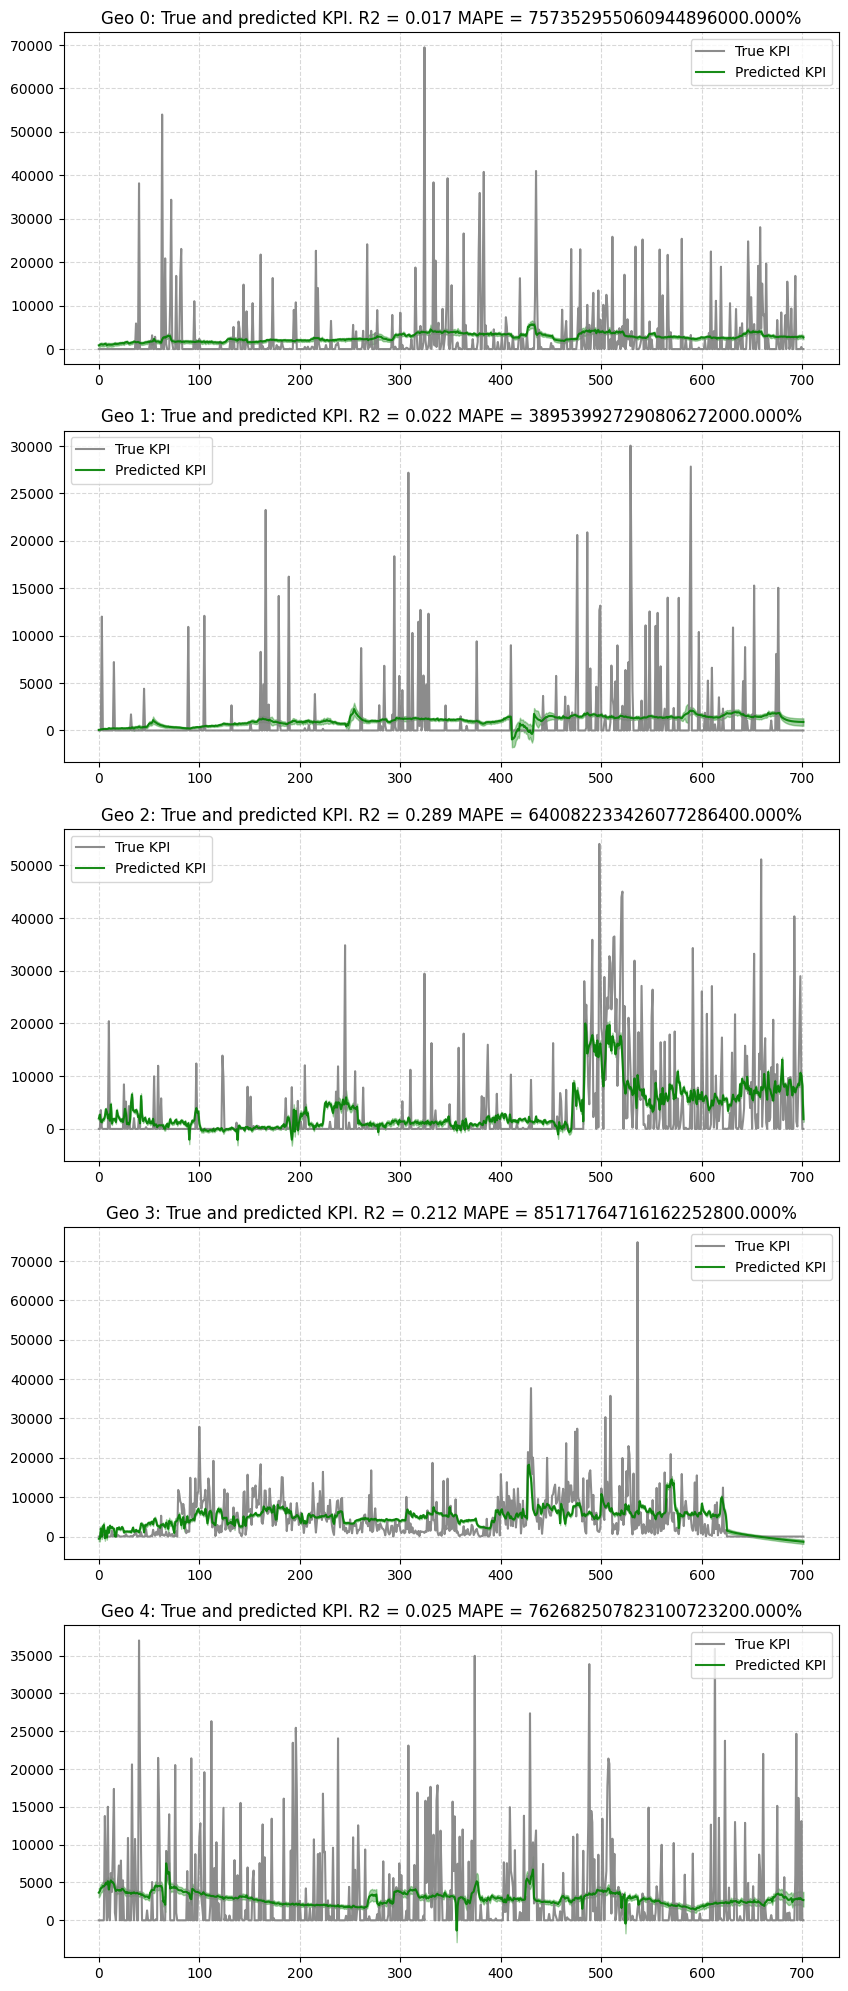

In [102]:
plot.plot_model_fit(mmm_coast_convert, target_scaler=target_scaler)

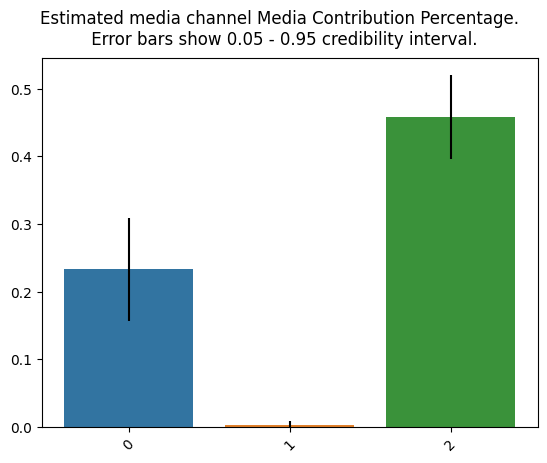

In [101]:
media_contribution_coast_convert, roi_hat_coast_convert = mmm_coast_convert.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)
plot.plot_bars_media_metrics(metric=media_contribution_coast_convert, metric_name="Media Contribution Percentage")

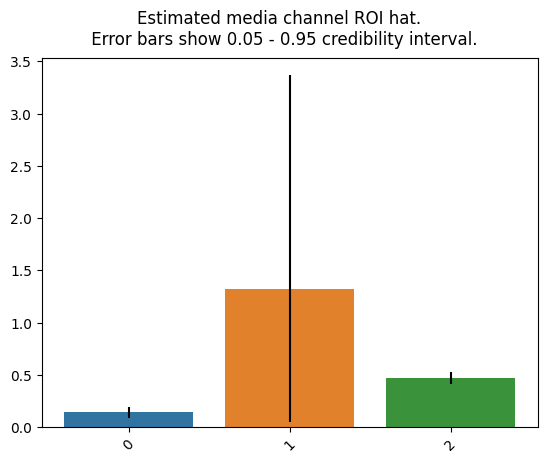

In [103]:
plot.plot_bars_media_metrics(metric=roi_hat_coast_convert, metric_name="ROI hat")

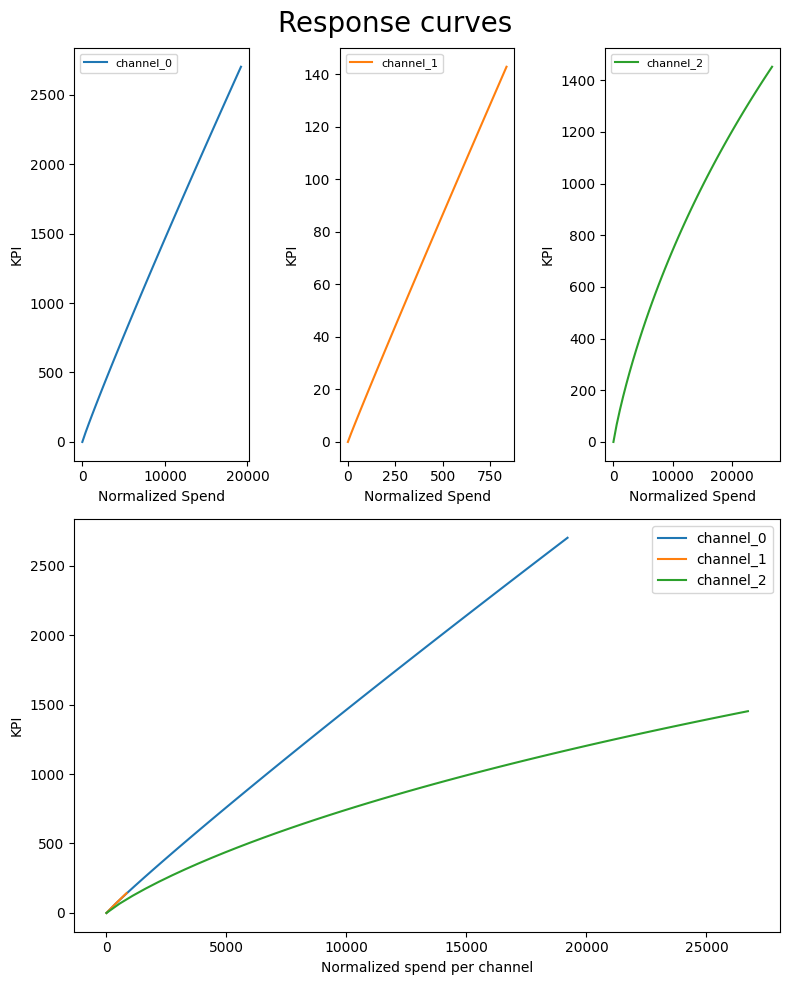

In [107]:
plot.plot_response_curves( media_mix_model=mmm_coast_convert, target_scaler=target_scaler, seed=SEED)

In [108]:
previous_budget_allocation_coast_convert,optimal_buget_allocation_coast_convert,solution_coast_convert,kpi_without_optim_coast_convert=optimal_budget(media_data_raw_coast_convert,media_data_rawcoast_convert,extra_test_coast_convert,mmm_coast_convert)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2142985.8656407674
            Iterations: 13
            Function evaluations: 102
            Gradient evaluations: 13


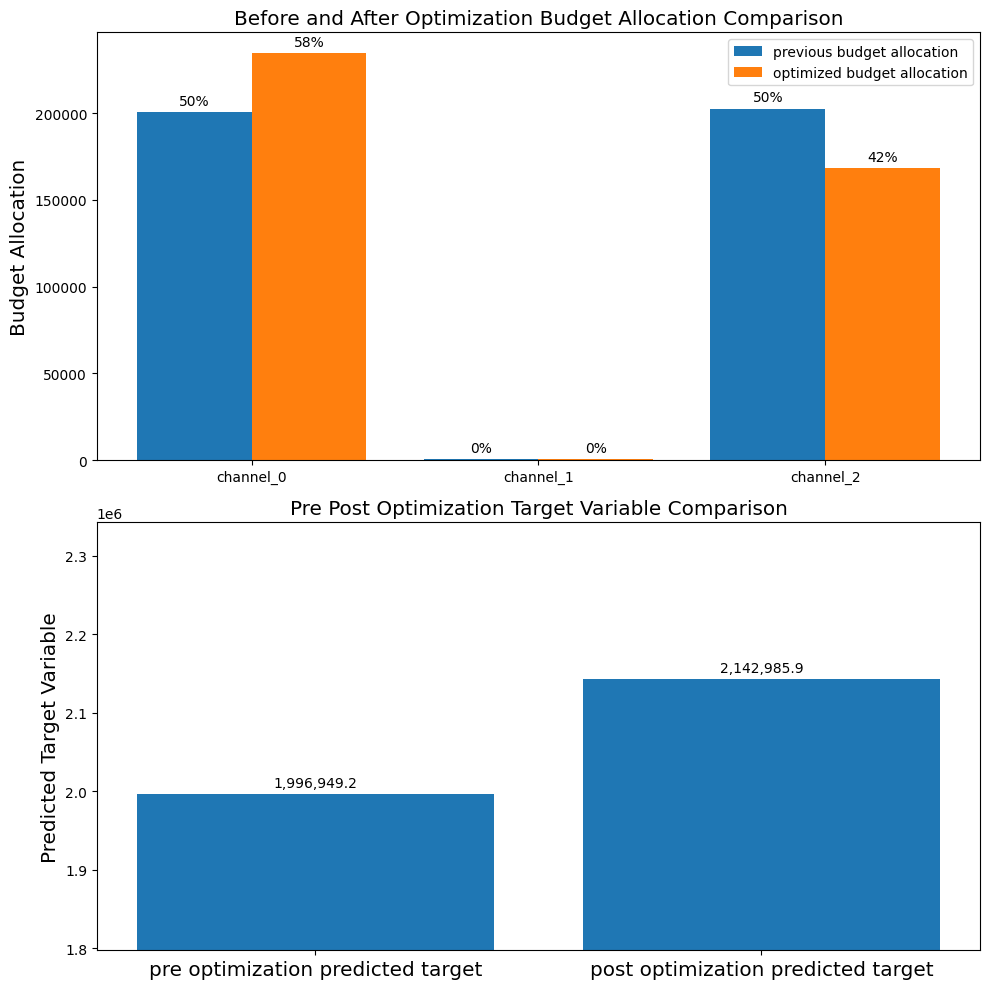

In [109]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm_coast_convert, 
                                                kpi_with_optim=solution_coast_convert['fun'], 
                                                kpi_without_optim=kpi_without_optim_coast_convert,
                                                optimal_buget_allocation=optimal_buget_allocation_coast_convert, 
                                                previous_budget_allocation=previous_budget_allocation_coast_convert,
                                                figure_size=(10,10))

### EXPEDITION NEW

In [110]:
#creating filtered df
exp_new=filtered_dataframe('EXP','New')

##less than 5% of the budget is allocated to these channels
channels_to_exclude = ['paid-social']
exp_new = exp_new[~exp_new['key_channel'].isin(channels_to_exclude)]

#grouping as per requirement
exp_new_grouped_dataframe=grouped_dataframe(exp_new)

#creating data required for model
media_data_raw_exp_new,sales_raw_exp_new,costs_raw_exp_new,extra_raw_exp_new=create_model_data(exp_new_grouped_dataframe)

#max market size
max_size_exp_new=get_max_market_size(exp_new,media_data_raw_exp_new,sales_raw_exp_new,extra_raw_exp_new)

#preprocessing data
split_point=60
media_data_train_scaled_exp_new, media_data_test_scaled_exp_new, target_train_scaled_exp_new, target_test_exp_new,media_names_exp_new, costs_scaled_exp_new, extra_train_scaled_exp_new,media_data_rawexp_new,sales_rawexp_new,extra_rawexp_new,extra_test_scaled_exp_new,extra_test_exp_new=preprocess_data(exp_new,media_data_raw_exp_new,sales_raw_exp_new,costs_raw_exp_new,extra_raw_exp_new,split_point,max_size_exp_new)

#data 
correlations_exp_new, variances_exp_new, spend_fractions_exp_new, variance_inflation_factors_exp_new=data_quality_check(media_data_train_scaled_exp_new,target_train_scaled_exp_new,costs_scaled_exp_new,extra_train_scaled_exp_new)

In [111]:
from IPython.display import display

for i, corr_matrix in enumerate(correlations_exp_new):
 display(f"geo {i}")
 display(corr_matrix.style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_precision(3))
 display("--------------------------------------------------------------------")

'geo 0'

,feature_0,feature_1,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,0.142,0.470,0.702,0.270,0.111,-0.077
feature_1,0.142,1.000,0.239,0.281,0.880,0.236,0.034
extra_feature_0,0.470,0.239,1.000,0.909,0.262,0.078,-0.035
extra_feature_1,0.702,0.281,0.909,1.000,0.375,0.113,-0.071
extra_feature_2,0.270,0.880,0.262,0.375,1.000,0.067,-0.043
extra_feature_3,0.111,0.236,0.078,0.113,0.067,1.000,0.073
target,-0.077,0.034,-0.035,-0.071,-0.043,0.073,1.000


'--------------------------------------------------------------------'

'geo 1'

,feature_0,feature_1,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,0.037,0.479,0.911,nan,0.450,0.059
feature_1,0.037,1.000,0.870,0.225,nan,0.113,-0.016
extra_feature_0,0.479,0.870,1.000,0.656,nan,0.313,0.017
extra_feature_1,0.911,0.225,0.656,1.000,nan,0.464,0.063
extra_feature_2,nan,nan,nan,nan,nan,nan,nan
extra_feature_3,0.450,0.113,0.313,0.464,nan,1.000,0.074
target,0.059,-0.016,0.017,0.063,nan,0.074,1.000


'--------------------------------------------------------------------'

'geo 2'

,feature_0,feature_1,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,-0.215,0.049,0.938,-0.201,0.508,0.019
feature_1,-0.215,1.000,0.819,-0.203,0.847,-0.119,-0.054
extra_feature_0,0.049,0.819,1.000,0.070,0.558,0.053,-0.052
extra_feature_1,0.938,-0.203,0.070,1.000,-0.194,0.500,0.026
extra_feature_2,-0.201,0.847,0.558,-0.194,1.000,-0.129,-0.049
extra_feature_3,0.508,-0.119,0.053,0.500,-0.129,1.000,0.094
target,0.019,-0.054,-0.052,0.026,-0.049,0.094,1.000


'--------------------------------------------------------------------'

'geo 3'

,feature_0,feature_1,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,0.625,0.847,nan,0.664,0.025
feature_1,nan,nan,nan,nan,nan,nan,nan
extra_feature_0,0.625,nan,1.000,0.869,nan,0.560,0.008
extra_feature_1,0.847,nan,0.869,1.000,nan,0.650,0.025
extra_feature_2,nan,nan,nan,nan,nan,nan,nan
extra_feature_3,0.664,nan,0.560,0.650,nan,1.000,0.057
target,0.025,nan,0.008,0.025,nan,0.057,1.000


'--------------------------------------------------------------------'

'geo 4'

,feature_0,feature_1,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,0.984,0.980,nan,0.496,nan
feature_1,nan,nan,nan,nan,nan,nan,nan
extra_feature_0,0.984,nan,1.000,0.997,nan,0.604,nan
extra_feature_1,0.980,nan,0.997,1.000,nan,0.587,nan
extra_feature_2,nan,nan,nan,nan,nan,nan,nan
extra_feature_3,0.496,nan,0.604,0.587,nan,1.000,nan
target,nan,nan,nan,nan,nan,nan,nan


'--------------------------------------------------------------------'

In [112]:
spend_fractions_exp_new.style.set_precision(4).applymap(highlight_low_spend_fractions)

,fraction of spend
feature_0,0.9587
feature_1,0.0413


In [113]:
variance_inflation_factors_exp_new.style.set_precision(4).applymap(highlight_high_vif_values)

,geo_0,geo_1,geo_2,geo_3,geo_4
feature_0,2.9474,7.4135,8.5611,4.7242,67.4550
feature_1,5.9664,32.3956,11.0380,nan,nan
extra_feature_0,9.5525,51.9563,4.7386,5.0207,357.7052
extra_feature_1,15.2280,16.5582,8.6075,10.6594,193.6649
extra_feature_2,6.3542,nan,4.5420,nan,nan
extra_feature_3,1.2384,1.2840,1.3627,1.9094,3.5801


In [114]:
number_warmup=1000
number_samples=1000
SEED=105    
mmm_exp_new=model_train("adstock")
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm_exp_new.fit(
    media=media_data_train_scaled_exp_new,
    media_prior=costs_scaled_exp_new,
    target=target_train_scaled_exp_new,
    extra_features=extra_train_scaled_exp_new,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED,
weekday_seasonality=True,
seasonality_frequency=365)

sample: 100%|███████████████████████████| 2000/2000 [00:09<00:00, 220.94it/s, 1 steps of size 2.91e-10. acc. prob=0.91]


In [115]:
mmm_exp_new.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
 channel_coef_media[0,0] 2066298.50 110182.34 2066250.25 1956096.88 2176403.75      1.00  23078.52
 channel_coef_media[1,0] 122191.69   8627.92 122189.06 113563.30 130814.82      1.00  23321.17
coef_extra_features[0,0]     -0.09      0.17     -0.09     -0.26      0.08      1.00 155013.02
coef_extra_features[0,1]     -0.22      0.03     -0.22     -0.25     -0.19      1.00  31686.22
coef_extra_features[0,2]      0.22      0.10      0.22      0.12      0.32      1.00 591248.81
coef_extra_features[0,3]     -0.16      0.21     -0.16     -0.37      0.04      1.00 1150891.25
coef_extra_features[0,4]     -0.09      0.24     -0.09     -0.34      0.15      1.00 339879.06
coef_extra_features[1,0]     -0.34      0.03     -0.34     -0.37     -0.31      1.00 137731.53
coef_extra_features[1,1]     -0.47      0.25     -0.47     -0.72     -0.21      1.00 487558.41
coef_extra_features[1,2]      0.19      0.05

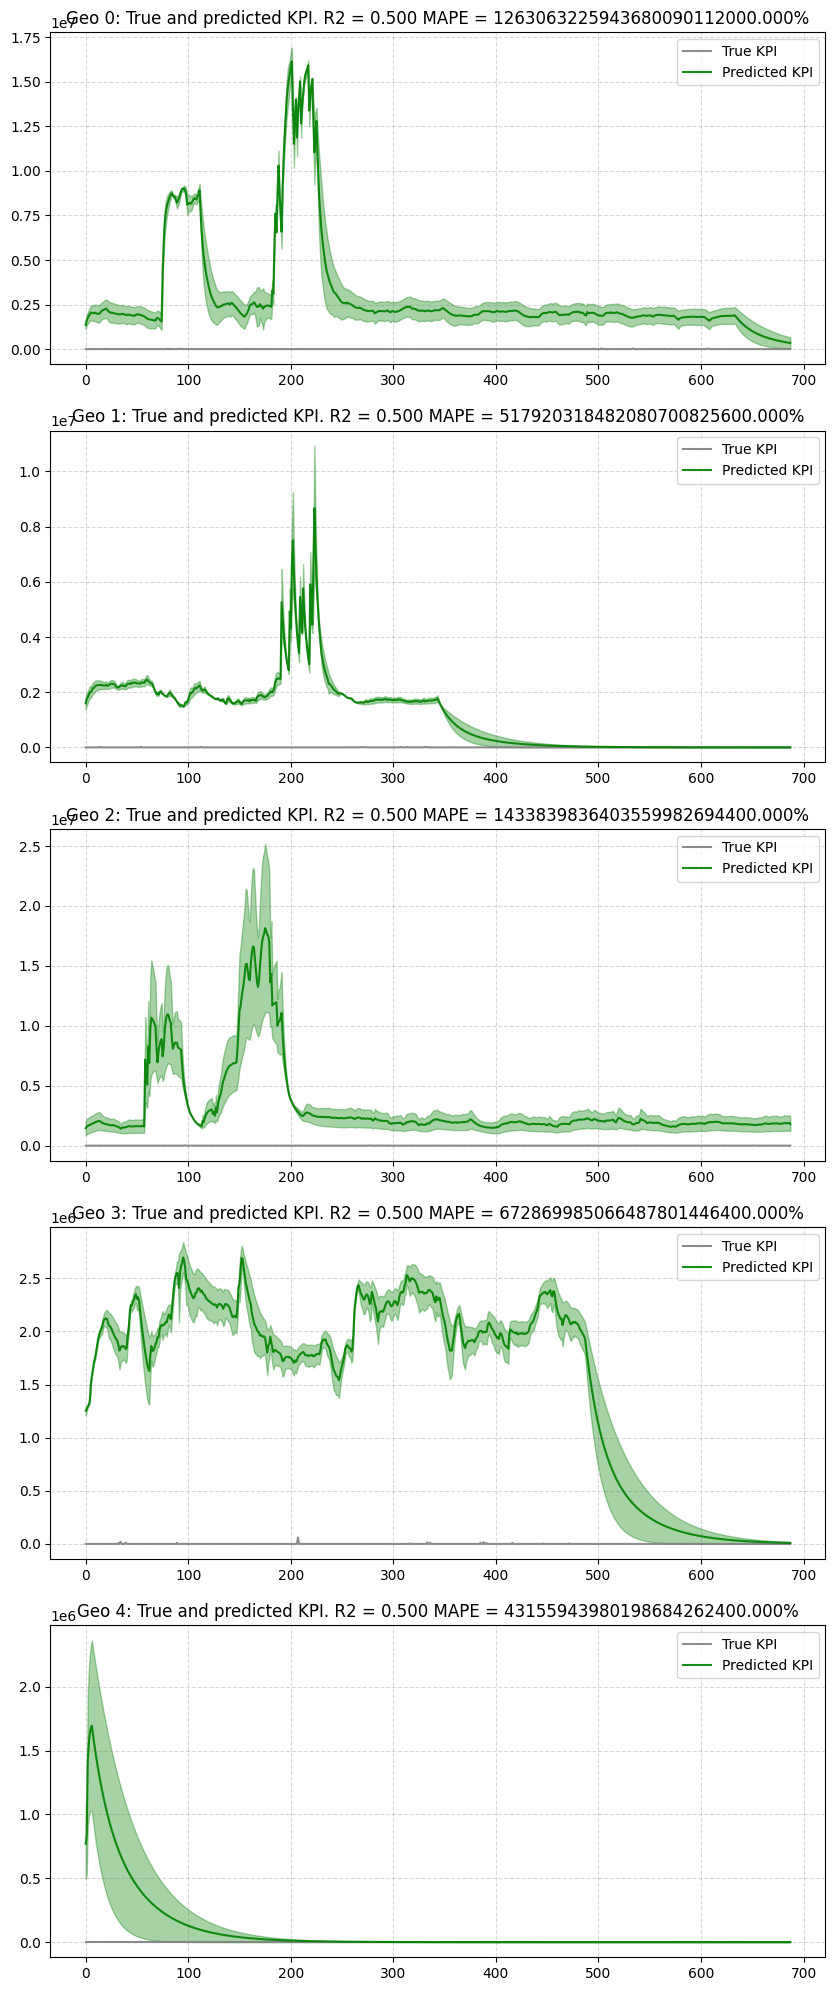

In [116]:
plot.plot_model_fit(mmm_exp_new, target_scaler=target_scaler)

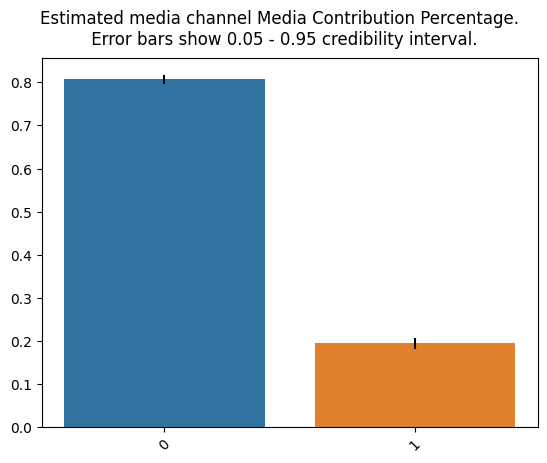

In [117]:
media_contribution_exp_new, roi_hat_exp_new = mmm_exp_new.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)
plot.plot_bars_media_metrics(metric=media_contribution_exp_new, metric_name="Media Contribution Percentage")

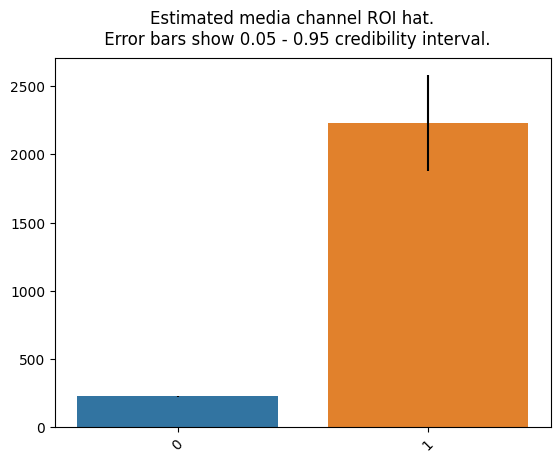

In [118]:
plot.plot_bars_media_metrics(metric=roi_hat_exp_new, metric_name="ROI hat")

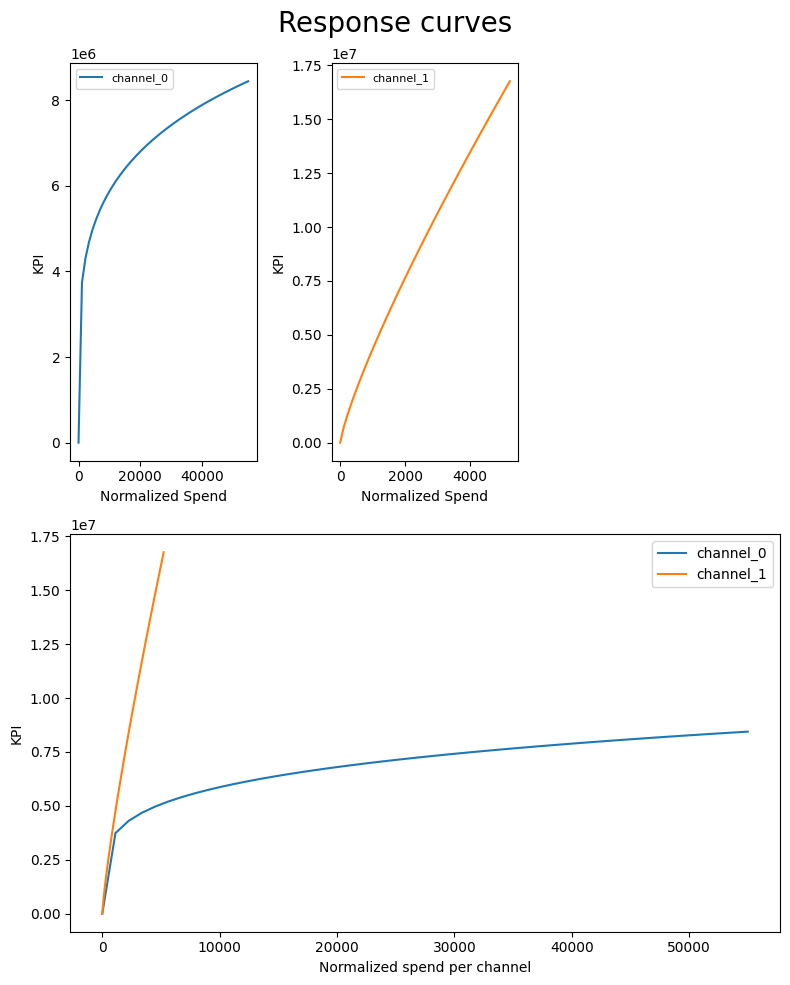

In [119]:
plot.plot_response_curves( media_mix_model=mmm_exp_new, target_scaler=target_scaler, seed=SEED)

In [120]:
previous_budget_allocation_exp_new,optimal_buget_allocation_exp_new,solution_exp_new,kpi_without_optim_exp_new=optimal_budget(media_data_raw_exp_new,media_data_rawexp_new,extra_test_exp_new,mmm_exp_new)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3074714503.611283
            Iterations: 7
            Function evaluations: 25
            Gradient evaluations: 5


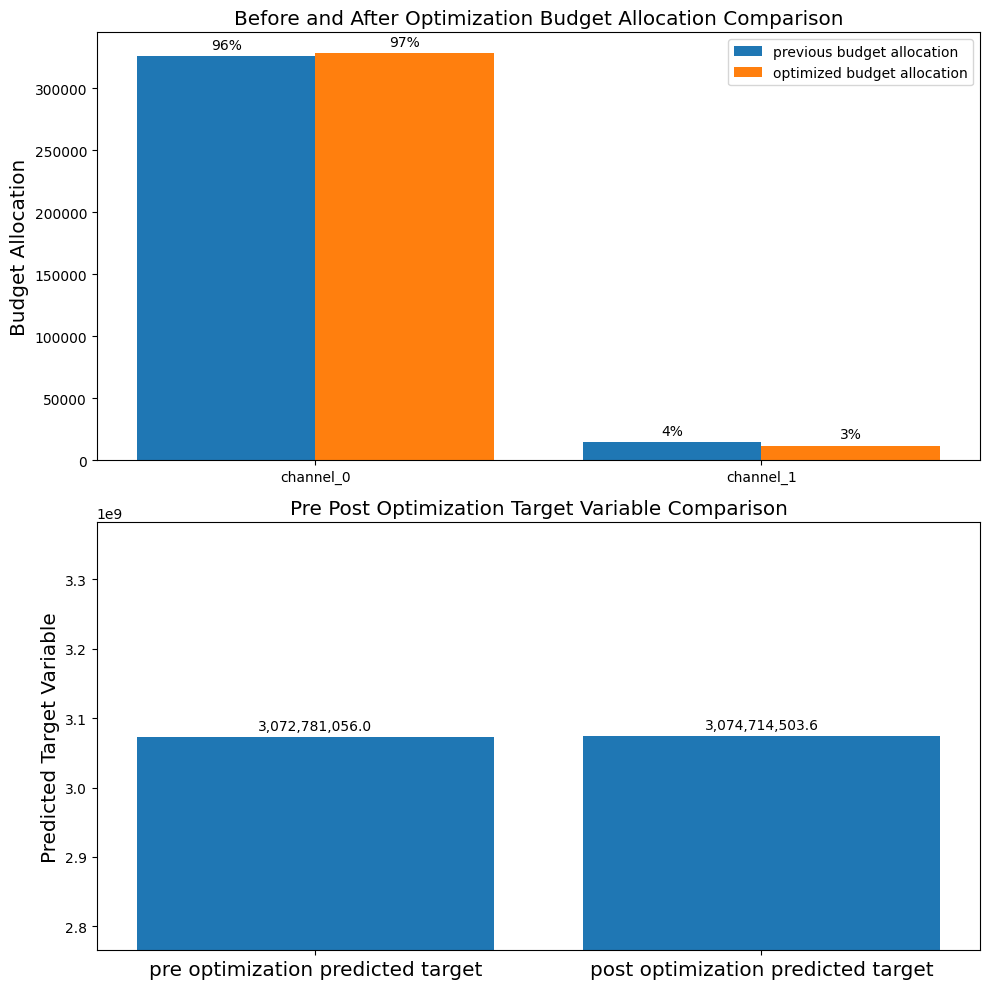

In [121]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm_exp_new, 
                                                kpi_with_optim=solution_exp_new['fun'], 
                                                kpi_without_optim=kpi_without_optim_exp_new,
                                                optimal_buget_allocation=optimal_buget_allocation_exp_new, 
                                                previous_budget_allocation=previous_budget_allocation_exp_new,
                                                figure_size=(10,10))

### EXPEDITION CONVERT

In [122]:
#creating filtered df
exp_convert=filtered_dataframe('EXP','Convert')

##less than 5% of the budget is allocated to these channels
#channels_to_exclude = ['paid-social']
#exp_convert = exp_convert[~exp_convert['key_channel'].isin(channels_to_exclude)]

#grouping as per requirement
exp_convert_grouped_dataframe=grouped_dataframe(exp_convert)

#creating data required for model
media_data_raw_exp_convert,sales_raw_exp_convert,costs_raw_exp_convert,extra_raw_exp_convert=create_model_data(exp_convert_grouped_dataframe)

#max market size
max_size_exp_convert=get_max_market_size(exp_convert,media_data_raw_exp_convert,sales_raw_exp_convert,extra_raw_exp_convert)

#preprocessing data
split_point=60
media_data_train_scaled_exp_convert, media_data_test_scaled_exp_convert, target_train_scaled_exp_convert, target_test_exp_convert,media_names_exp_convert, costs_scaled_exp_convert, extra_train_scaled_exp_convert,media_data_rawexp_convert,sales_rawexp_convert,extra_rawexp_convert,extra_test_scaled_exp_convert,extra_test_exp_convert=preprocess_data(exp_convert,media_data_raw_exp_convert,sales_raw_exp_convert,costs_raw_exp_convert,extra_raw_exp_convert,split_point,max_size_exp_convert)

#data 
correlations_exp_convert, variances_exp_convert, spend_fractions_exp_convert, variance_inflation_factors_exp_convert=data_quality_check(media_data_train_scaled_exp_convert,target_train_scaled_exp_convert,costs_scaled_exp_convert,extra_train_scaled_exp_convert)

In [123]:
from IPython.display import display

for i, corr_matrix in enumerate(correlations_exp_convert):
 display(f"geo {i}")
 display(corr_matrix.style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_precision(3))
 display("--------------------------------------------------------------------")

'geo 0'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,-0.014,0.092,0.153,0.017,-0.023,0.090
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,-0.014,nan,1.000,0.774,0.415,0.575,0.426,-0.039
extra_feature_0,0.092,nan,0.774,1.000,0.543,0.623,0.357,-0.059
extra_feature_1,0.153,nan,0.415,0.543,1.000,0.061,0.352,0.020
extra_feature_2,0.017,nan,0.575,0.623,0.061,1.000,0.103,-0.087
extra_feature_3,-0.023,nan,0.426,0.357,0.352,0.103,1.000,0.049
target,0.090,nan,-0.039,-0.059,0.020,-0.087,0.049,1.000


'--------------------------------------------------------------------'

'geo 1'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,0.327,0.303,0.473,0.295,0.363,0.065
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,0.327,nan,1.000,0.547,0.363,0.357,0.417,-0.010
extra_feature_0,0.303,nan,0.547,1.000,0.768,0.349,0.288,-0.006
extra_feature_1,0.473,nan,0.363,0.768,1.000,0.336,0.331,0.047
extra_feature_2,0.295,nan,0.357,0.349,0.336,1.000,0.133,-0.016
extra_feature_3,0.363,nan,0.417,0.288,0.331,0.133,1.000,0.122
target,0.065,nan,-0.010,-0.006,0.047,-0.016,0.122,1.000


'--------------------------------------------------------------------'

'geo 2'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,0.231,0.257,0.549,0.827,0.436,0.056,0.189
feature_1,0.231,1.000,0.033,0.040,0.201,0.015,-0.072,0.095
feature_2,0.257,0.033,1.000,0.855,0.548,0.883,0.271,0.032
extra_feature_0,0.549,0.040,0.855,1.000,0.794,0.933,0.348,0.065
extra_feature_1,0.827,0.201,0.548,0.794,1.000,0.655,0.256,0.152
extra_feature_2,0.436,0.015,0.883,0.933,0.655,1.000,0.328,0.029
extra_feature_3,0.056,-0.072,0.271,0.348,0.256,0.328,1.000,0.071
target,0.189,0.095,0.032,0.065,0.152,0.029,0.071,1.000


'--------------------------------------------------------------------'

'geo 3'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,0.116,-0.414,-0.306,0.055,-0.426,-0.316,0.069
feature_1,0.116,1.000,-0.055,0.001,0.002,0.049,-0.045,0.038
feature_2,-0.414,-0.055,1.000,0.927,0.552,0.924,0.581,0.055
extra_feature_0,-0.306,0.001,0.927,1.000,0.725,0.837,0.580,0.072
extra_feature_1,0.055,0.002,0.552,0.725,1.000,0.395,0.397,0.020
extra_feature_2,-0.426,0.049,0.924,0.837,0.395,1.000,0.522,0.073
extra_feature_3,-0.316,-0.045,0.581,0.580,0.397,0.522,1.000,0.065
target,0.069,0.038,0.055,0.072,0.020,0.073,0.065,1.000


'--------------------------------------------------------------------'

'geo 4'

,feature_0,feature_1,feature_2,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
feature_0,1.000,nan,0.170,0.303,0.474,0.241,0.408,0.260
feature_1,nan,nan,nan,nan,nan,nan,nan,nan
feature_2,0.170,nan,1.000,0.267,0.249,-0.071,0.411,0.244
extra_feature_0,0.303,nan,0.267,1.000,0.793,0.458,0.214,0.027
extra_feature_1,0.474,nan,0.249,0.793,1.000,0.403,0.582,0.254
extra_feature_2,0.241,nan,-0.071,0.458,0.403,1.000,-0.002,0.022
extra_feature_3,0.408,nan,0.411,0.214,0.582,-0.002,1.000,0.542
target,0.260,nan,0.244,0.027,0.254,0.022,0.542,1.000


'--------------------------------------------------------------------'

In [124]:
spend_fractions_exp_convert.style.set_precision(4).applymap(highlight_low_spend_fractions)

,fraction of spend
feature_0,0.3456
feature_1,0.0012
feature_2,0.6532


In [125]:
variance_inflation_factors_exp_convert.style.set_precision(4).applymap(highlight_high_vif_values)

,geo_0,geo_1,geo_2,geo_3,geo_4
feature_0,1.0468,1.4809,4.4021,1.4523,1.3667
feature_1,nan,nan,1.1185,1.1262,nan
feature_2,2.8721,1.7881,6.0868,17.0600,1.4039
extra_feature_0,3.8669,3.2385,16.6059,14.0807,4.2087
extra_feature_1,1.7999,3.0942,7.8713,3.4330,6.0446
extra_feature_2,2.1244,1.2486,11.0396,8.7527,1.4000
extra_feature_3,1.3141,1.3392,1.2428,1.5765,2.6550


In [126]:
number_warmup=1000
number_samples=1000
SEED=105    
mmm_exp_convert=model_train("adstock")
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm_exp_convert.fit(
    media=media_data_train_scaled_exp_convert,
    media_prior=costs_scaled_exp_convert,
    target=target_train_scaled_exp_convert,
    extra_features=extra_train_scaled_exp_convert,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED,
weekday_seasonality=True,
seasonality_frequency=365)

sample: 100%|██████████████████████████| 2000/2000 [04:25<00:00,  7.54it/s, 127 steps of size 3.08e-02. acc. prob=0.93]


In [127]:
mmm_exp_convert.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
 channel_coef_media[0,0]     82.38     76.28     61.30      6.11    161.52    540.30      1.00
 channel_coef_media[1,0]   3286.60   3613.69   1952.80     24.28   8273.98    530.59      1.00
 channel_coef_media[2,0]     55.36     35.30     47.56     14.14     94.80    875.97      1.00
coef_extra_features[0,0]     -0.00      0.00     -0.00     -0.00     -0.00   2378.68      1.00
coef_extra_features[0,1]     -0.01      0.00     -0.01     -0.01     -0.00   2468.80      1.00
coef_extra_features[0,2]     -0.00      0.00     -0.00     -0.00      0.00   2762.85      1.00
coef_extra_features[0,3]      0.00      0.00      0.00      0.00      0.01   2394.74      1.00
coef_extra_features[0,4]     -0.03      0.00     -0.03     -0.03     -0.02   2579.91      1.00
coef_extra_features[1,0]      0.14      0.04      0.14      0.07      0.22   2618.88      1.00
coef_extra_features[1,1]      0.72      0.27     

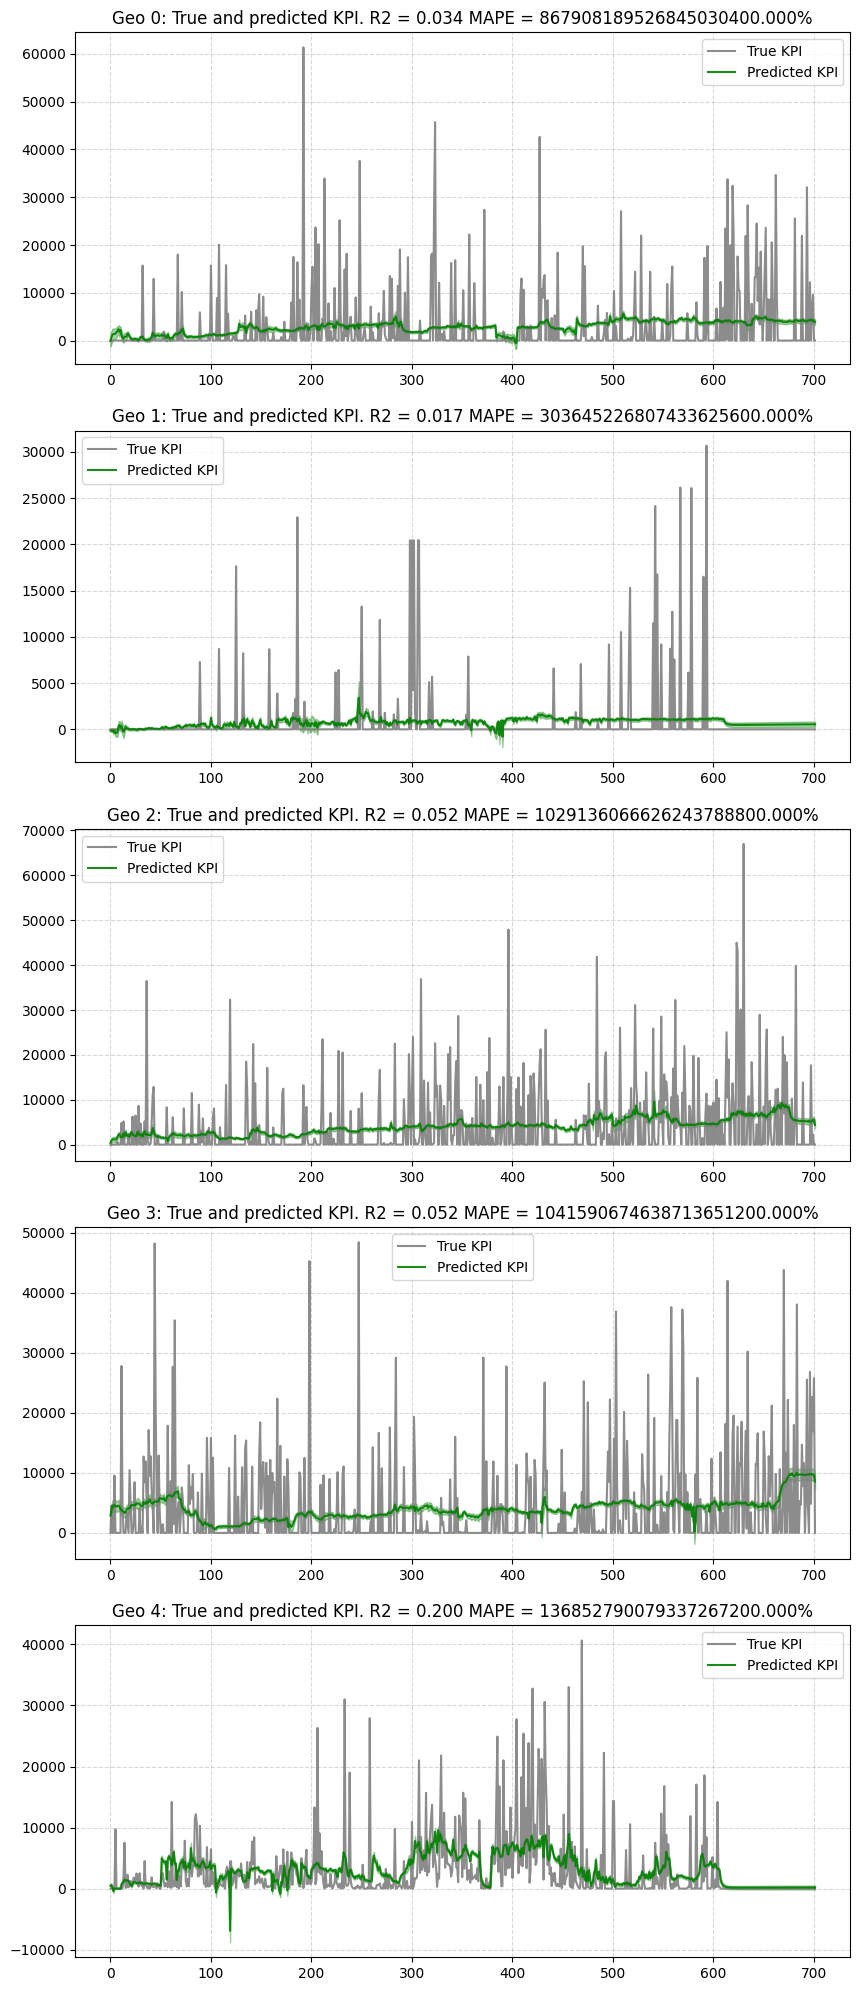

In [133]:
plot.plot_model_fit(mmm_exp_convert, target_scaler=target_scaler)

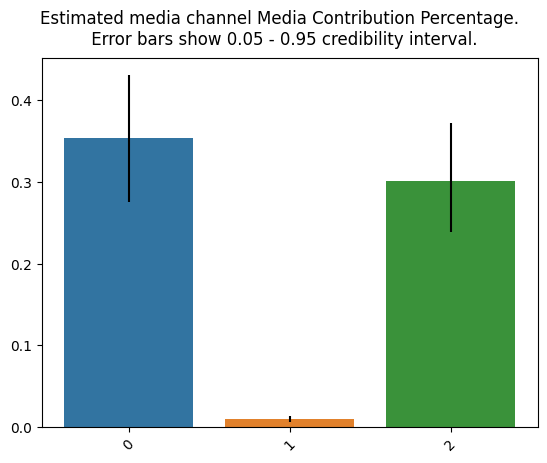

In [134]:
media_contribution_exp_convert, roi_hat_exp_convert = mmm_exp_convert.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)
plot.plot_bars_media_metrics(metric=media_contribution_exp_convert, metric_name="Media Contribution Percentage")

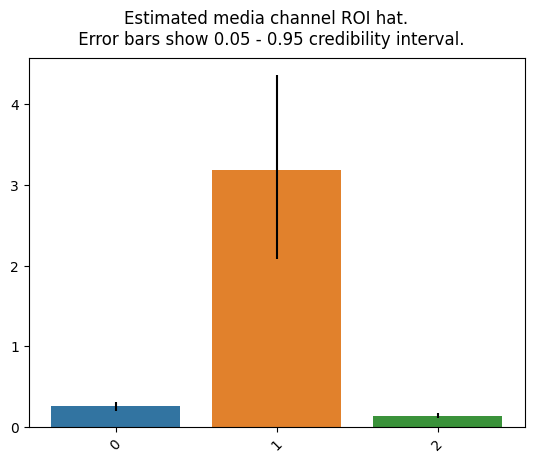

In [135]:
plot.plot_bars_media_metrics(metric=roi_hat_exp_convert, metric_name="ROI hat")


In [252]:
previous_budget_allocation_exp_convert,optimal_buget_allocation_exp_convert,solution_exp_convert,kpi_without_optim_exp_convert=optimal_budget(media_data_raw_exp_convert,media_data_rawexp_convert,extra_test_exp_convert,mmm_exp_convert)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -5562782.611749245
            Iterations: 14
            Function evaluations: 91
            Gradient evaluations: 13


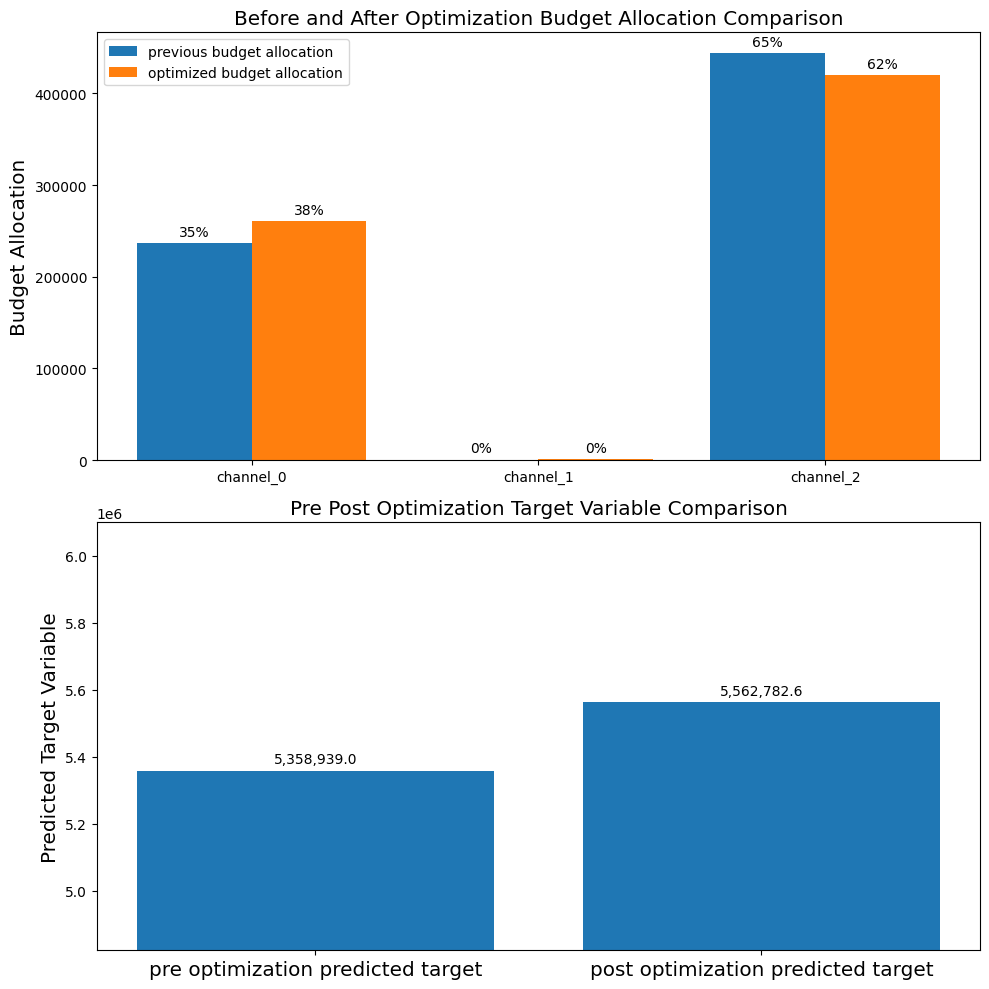

In [132]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm_exp_convert, 
                                                kpi_with_optim=solution_exp_convert['fun'], 
                                                kpi_without_optim=kpi_without_optim_exp_convert,
                                                optimal_buget_allocation=optimal_buget_allocation_exp_convert, 
                                                previous_budget_allocation=previous_budget_allocation_exp_convert,
                                                figure_size=(10,10))

## LIGHTWEIGHT MARKETING MIX MODEL-NATIONAL LEVEL

In [258]:
## function to group dataframes in required format
def grouped_national_dataframe(dataframe):
    df = dataframe.groupby(["full_date", "key_channel"])[["total_impressions","total_clicks","total_video_views","conversions","total_spend","revenue"]].sum()
    return df


## fucntion to create media,sale,cost and extra features data
def create_national_model_data(dataframe):
    
    media_data_raw_ = dataframe['conversions'].unstack(level=1).fillna(0) 
    #conversion is taken as the kpi for new campaigns
    sales_raw_ = dataframe['revenue'].reset_index().groupby(["full_date"]).sum()
    costs_raw = dataframe.groupby(["full_date", "key_channel"])[["total_spend"]].sum().unstack()
    extra_raw_=dataframe[["total_clicks","total_video_views","total_impressions"]].groupby(["full_date"]).sum()
    return media_data_raw_,sales_raw_,costs_raw,extra_raw_



 ##function to pre-process data for modelling
def preprocess_national_data(dataframe, media_data_raw_, sales_raw_,costs_raw,extra_raw_,split_point):

    # Splitting the data into train and test and scaling it
    split_point = split_point
    media_data_test = media_data_raw_.iloc[:split_point, :]
    media_data_train = media_data_raw_.iloc[split_point:, :]
    target_test = sales_raw_.iloc[:split_point, :]
    target_train = sales_raw_.iloc[split_point:, :]
    extra_test = extra_raw_.iloc[:split_point, :]
    extra_train = extra_raw_.iloc[split_point:, :]
    media_names = media_data_raw_.columns
    costs_train = costs_raw.iloc[split_point:].sum(axis=0)
    media_scaler = preprocessing.CustomScaler()
    target_scaler = preprocessing.CustomScaler()
    cost_scaler = preprocessing.CustomScaler()
    extra_scaler = preprocessing.CustomScaler()
    

    media_data_train = media_data_train.values.astype(np.float32)
    extra_train = extra_train.values.astype(np.float32)
    extra_train_scaled = extra_scaler.fit_transform(extra_train)
    extra_test=extra_test.values.astype(np.float32)
    extra_test_scaled=extra_scaler.fit_transform(extra_test)
    media_data_train_scaled = media_scaler.fit_transform(media_data_train)
    target_train = target_train.values.astype(np.float32)
    target_train_scaled = target_scaler.fit_transform(target_train.squeeze())
    costs_train = costs_train.values.astype(np.float32)  # Convert to NumPy array
    costs_scaled = cost_scaler.fit_transform(costs_train)
    media_data_test_scaled = media_scaler.transform(media_data_test)
    return (media_data_train_scaled, media_data_test_scaled, target_train_scaled, target_test,
            media_names, costs_scaled,extra_train_scaled,extra_test_scaled,extra_test)


In [265]:
#creating filtered df
US=data[data['market']=='United States']
US=US[US['tactic']=='Convert']

##less than 5% of the budget is allocated to these channels
channels_to_exclude = ['paid-social']
US = US[~US['key_channel'].isin(channels_to_exclude)]

#grouping as per requirement
US_grouped_dataframe=grouped_national_dataframe(US)


#creating data required for model
media_data_raw_US,sales_raw_US,costs_raw_US,extra_raw_US=create_national_model_data(US_grouped_dataframe)


#preprocessing data
split_point=60
media_data_train_scaled_US, media_data_test_scaled_US, target_train_scaled_US, target_test_US,media_names_US, costs_scaled_US, extra_train_scaled_US,extra_test_scaled_US,extra_test_US=preprocess_national_data(US,media_data_raw_US,sales_raw_US,costs_raw_US,extra_raw_US,split_point)

#data 
correlations_US, variances_US, spend_fractions_US, variance_inflation_factors_US=data_quality_check(media_data_train_scaled_US,target_train_scaled_US,costs_scaled_US,extra_train_scaled_US)

In [266]:
correlations_US[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_precision(3)

,feature_0,feature_1,extra_feature_0,extra_feature_1,extra_feature_2,target
feature_0,1.000,-0.265,0.177,-0.145,-0.058,0.244
feature_1,-0.265,1.000,-0.065,0.131,0.357,-0.008
extra_feature_0,0.177,-0.065,1.000,0.075,0.582,0.096
extra_feature_1,-0.145,0.131,0.075,1.000,0.359,-0.080
extra_feature_2,-0.058,0.357,0.582,0.359,1.000,0.009
target,0.244,-0.008,0.096,-0.080,0.009,1.000


In [228]:
spend_fractions_US.style.set_precision(4).applymap(highlight_low_spend_fractions)

,fraction of spend
feature_0,0.4057
feature_1,0.5943


In [229]:
variance_inflation_factors_US.style.set_precision(4).applymap(highlight_high_vif_values)

,geo_0
feature_0,1.5520
feature_1,1.7329
extra_feature_0,2.2961
extra_feature_1,2.4948
extra_feature_2,3.8491


In [240]:
number_warmup=1000
number_samples=1000
SEED=105    
mmm_US=model_train("carryover")
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm_US.fit(
    media=media_data_train_scaled_US,
    media_prior=costs_scaled_US,
    target=target_train_scaled_US,
    extra_features=extra_train_scaled_US,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED,
weekday_seasonality=True,
seasonality_frequency=365)

sample: 100%|██████████████████████████| 2000/2000 [01:59<00:00, 16.68it/s, 127 steps of size 2.38e-02. acc. prob=0.93]


In [241]:
mmm_US.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.18      0.14      0.14      0.00      0.37   1454.65      1.00
ad_effect_retention_rate[1]      0.12      0.11      0.08      0.00      0.28   1566.41      1.00
     coef_extra_features[0]      0.37      0.08      0.38      0.23      0.51   1904.36      1.00
     coef_extra_features[1]     -0.03      0.00     -0.03     -0.03     -0.02   2947.67      1.00
     coef_extra_features[2]      0.00      0.00      0.00      0.00      0.01   2204.11      1.00
              coef_media[0]     55.36     19.00     52.47     25.03     81.39   1019.62      1.00
              coef_media[1]     35.37     32.69     25.50      8.26     67.63    927.85      1.00
              coef_trend[0]      1.34      0.62      1.24      0.43      2.25    990.25      1.00
                 expo_trend      1.35      0.07      1.34      1.24      1.48    882.27      1.00
                exp

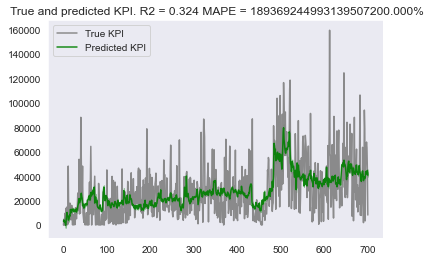

In [242]:
plot.plot_model_fit(mmm_US, target_scaler=target_scaler)

In [243]:
media_contribution_US, roi_hat_US = mmm_US.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

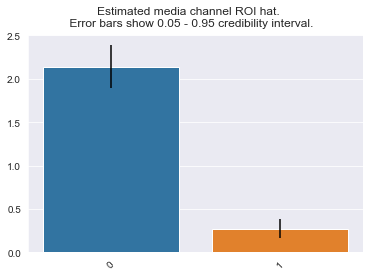

In [244]:
plot.plot_bars_media_metrics(metric=roi_hat_US, metric_name="ROI hat")

In [247]:
media_data_rawUS=media_data_raw_US.values.astype(int)
extra_scaler = preprocessing.CustomScaler()

In [253]:
previous_budget_allocation_US,optimal_buget_allocation_US,solution_US,kpi_without_optim_US=optimal_budget(media_data_raw_US,media_data_rawUS,extra_test_scaled_US,mmm_US)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1756817.9115805165
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 6


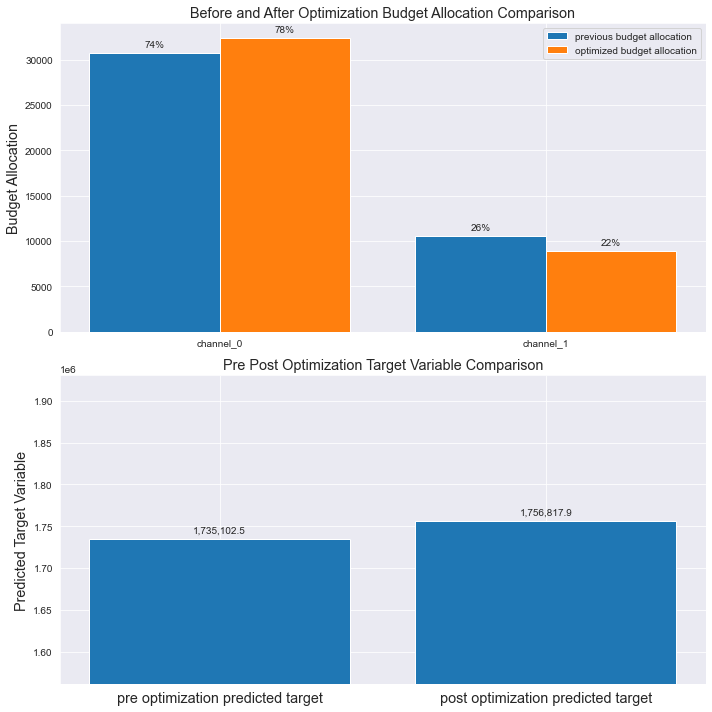

In [254]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm_US, 
                                                kpi_with_optim=solution_US['fun'], 
                                                kpi_without_optim=kpi_without_optim_US,
                                                optimal_buget_allocation=optimal_buget_allocation_US, 
                                                previous_budget_allocation=previous_budget_allocation_US,
                                                figure_size=(10,10))